# 1. Benchmarking Updated
Runs comparison benchmarks for reference and mixture datasets across a number of competing methods.

## Creating Environment
The following was used to create the testing environment for this script

In [ ]:
#%%bash
#conda create -n "testingenv" python=3.8.15
#conda activate testingenv
#pip3 install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html


#python
#from scvi_colab import install
#install(run_outside_colab = True)

#pip install --quiet git+https://github.com/BayraktarLab/cell2location#egg=cell2location[tutorials]

## Loading Packages

In [1]:
import scvi
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import os, csv
from scipy.stats import pearsonr

Global seed set to 0
/opt/conda/envs/testingenv/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/opt/conda/envs/testingenv/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [ ]:
import scvi
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from scvi.external import RNAStereoscope, SpatialStereoscope
import cell2location
import warnings
import os
import csv
from scipy.stats import pearsonr
warnings.filterwarnings('ignore')

In [2]:
# Add repo path to system path if it is not already there
# This allows us to import the package
import sys
GIT_REPO_PATH = "/home/jupyter/github_repos/"
if GIT_REPO_PATH not in sys.path: sys.path.append(GIT_REPO_PATH)

from ucdeconvolve.ucdeconvolve._utils import collapse_anndata

In [3]:
def ccc(
    x : np.ndarray,
    y : np.ndarray,
) -> float:
    """\
    Concordance Correlation Coefficient
    
    Computes CCC for two equal sized 1D arrays.
    
    Params
    ------
    x
        An array
    y
        An array
        
    Returns
    -------
    ccc_val : float
        The ccc value
        
    """
    
    x = np.array(x)
    y = np.array(y)
    
    mu_x = np.mean(x)
    mu_y = np.mean(y)
    
    cov = np.sum((x - mu_x) * (y - mu_y)) * (1 / len(y))
    
    var_x = np.std(x) ** 2
    var_y = np.std(y) ** 2
    ccc = (2 * cov) / (var_x + var_y + np.squeeze((mu_x - mu_y) ** 2))
    
    return ccc, _

# StarMap Dataset

In [4]:
# Get base path
basepath = "/home/jupyter/manuscript/figure2_old/data/additional_benchmarking/starmap/"

# Load datasetsa
adata_reference = sc.read_h5ad(os.path.join(basepath, "adata_starmap_reference.h5ad"))
adata_mixture = sc.read_h5ad(os.path.join(basepath, "adata_starmap_mixture.h5ad"))

# Mixtures undo log transofrm, norm to 10,000 if not already
adata_mixture.X = np.expm1(adata_mixture.X)
sc.pp.normalize_total(adata_mixture, 1e4)

# Reference undo log transofrm, norm to 10,000 if not already
adata_reference.X = np.expm1(adata_reference.X)
sc.pp.normalize_total(adata_mixture, 1e4)

# Subet top 7,000 genes only to reduce computational overhead
adata_reference.layers["counts"] = adata_reference.X.copy()

# Intersect common genes
intersect = np.intersect1d(adata_mixture.var_names, adata_reference.var_names)
adata_mixture = adata_mixture[:, intersect]
adata_reference = adata_reference[:, intersect]

# Only keep known references
adata_reference = adata_reference[adata_reference.obs.celltype.ne('Unknown')]

# Make explicit copies
adata_reference = adata_reference.copy()
adata_mixture = adata_mixture.copy()

# Setup layers
adata_reference.X = adata_reference.X.astype(np.int32)
adata_reference.layers["counts"] = adata_reference.layers["counts"].astype(np.int32)

adata_mixture.layers["counts"] = adata_mixture.X.copy()
adata_mixture.X = adata_mixture.X.astype(np.int32)
adata_mixture.layers["counts"] = adata_mixture.layers["counts"].astype(np.int32)

## Run Deconvolution

### Stereoscope

In [ ]:
RNAStereoscope.setup_anndata(adata_reference, layer = "counts", labels_key = "celltype")
reference_model = RNAStereoscope(adata_reference)
reference_model.train(max_epochs = 100)
reference_model.history["elbo_train"][10:].plot()
reference_model.save("reference_model", overwrite=True)

In [ ]:
RNAStereoscope.setup_anndata(adata_mixture, layer="counts")

mixture_model = SpatialStereoscope.from_rna_model(adata_mixture, reference_model)
mixture_model.train(max_epochs = 3000)
mixture_model.history["elbo_train"][10:].plot()
mixture_model.save("mixture_model", overwrite = True)

In [ ]:
celltype_preds_mixture_stereoscope = mixture_model.get_proportions()
celltype_preds_mixture_stereoscope = (celltype_preds_mixture_stereoscope.T / celltype_preds_mixture_stereoscope.T.sum(0)).T

preds = celltype_preds_mixture_stereoscope
common_celltypes = list(set(adata_mixture.obs.columns).intersection(set(preds.columns)))
res = pd.DataFrame([[c, ccc(adata_mixture.obs[c].values, preds[c].values)[0], pearsonr(adata_mixture.obs[c].values, preds[c].values)[0]] \
                        for c in common_celltypes],columns = ['celltype', 'ccc','pearsonr']).set_index('celltype')

preds.to_csv("/home/jupyter/manuscript/figure2/data/additional_benchmarking/starmap/results/preds_starmap_stereoscope.csv", sep = ",")
print(res.round(2), res.mean(),res.std())

### DestVI

In [ ]:
from scvi.model import CondSCVI, DestVI

CondSCVI.setup_anndata(adata_reference, layer="counts", labels_key="celltype")
reference_model_destvi = CondSCVI(adata_reference, weight_obs=True)

reference_model_destvi.train(max_epochs=1000)
reference_model_destvi.history["elbo_train"][10:].plot()

In [ ]:
DestVI.setup_anndata(adata_mixture, layer="counts")
mixture_model_destvi = DestVI.from_rna_model(adata_mixture, reference_model_destvi)
mixture_model_destvi.train(max_epochs=2500)
mixture_model_destvi.history["elbo_train"][10:].plot()

In [ ]:
celltype_preds_mixture_destvi = mixture_model_destvi.get_proportions()
celltype_preds_mixture_destvi = (celltype_preds_mixture_destvi.T / celltype_preds_mixture_destvi.T.sum(0)).T

preds = celltype_preds_mixture_destvi
common_celltypes = list(set(adata_mixture.obs.columns).intersection(set(preds.columns)))

res = pd.DataFrame([[c, ccc(adata_mixture.obs[c].values, preds[c].values)[0], pearsonr(adata_mixture.obs[c].values, preds[c].values)[0]] \
                        for c in common_celltypes],columns = ['celltype', 'ccc','pearsonr']).set_index('celltype')
preds.to_csv("/home/jupyter/manuscript/figure2/data/additional_benchmarking/starmap/results/preds_starmap_destvi.csv", sep = ",")
print(res.round(2), res.mean(),res.std())

### Cell2Location

In [ ]:
import cell2location
from cell2location.models import RegressionModel

# Prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_reference, labels_key='celltype')

# Create Regression Model
mod = RegressionModel(adata_reference)

# Train the Regression Model
mod.train(max_epochs=2000, use_gpu=True)

In [ ]:
# Let's check our model output to make sure the training curve looks good
mod.plot_history(20)

In [ ]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_reference = mod.export_posterior(adata_reference, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True})
mod.plot_QC()

In [ ]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_reference.varm.keys():
    inf_aver = adata_reference.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_reference.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_reference.var[[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_reference.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_reference.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

In [ ]:
# Setup anndata object for mixture
cell2location.models.Cell2location.setup_anndata(adata=adata_mixture)

# create and train the model
mod = cell2location.models.Cell2location(
    adata_mixture, cell_state_df=inf_aver,
    N_cells_per_location=5,
    detection_alpha=20
)
mod.view_anndata_setup()

In [ ]:
mod.train(max_epochs=8000,
          batch_size=None,
          train_size=1,
          use_gpu=True)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [ ]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_mixture = mod.export_posterior(adata_mixture, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True})

# Examine reconstruction accuracy to assess if there are any issues with mapping
# the plot should be roughly diagonal, strong deviations will signal problems
mod.plot_QC()

In [ ]:
celltype_preds_mixture = adata_mixture.obsm['q05_cell_abundance_w_sf'].copy()
celltype_preds_mixture.columns = celltype_preds_mixture.columns.str[23:]
celltype_preds_mixture = (celltype_preds_mixture.T / celltype_preds_mixture.T.sum(0)).T

preds = celltype_preds_mixture
common_celltypes = list(set(adata_mixture.obs.columns).intersection(set(preds.columns)))
res = pd.DataFrame([[c, ccc(adata_mixture.obs[c].values, preds[c].values)[0], pearsonr(adata_mixture.obs[c].values, preds[c].values)[0]] \
                        for c in common_celltypes],columns = ['celltype', 'ccc','pearsonr']).set_index('celltype')
preds.to_csv("/home/jupyter/manuscript/figure2/data/additional_benchmarking/starmap/results/preds_starmap_cell2location.csv", sep = ",")
print(res, res.mean(),res.std())

### Tangram

In [ ]:
import tangram as tg
import time

start = time.time()
tg.pp_adatas(adata_reference, adata_mixture)
ad_map = tg.map_cells_to_space(adata_reference, adata_mixture, mode='clusters', cluster_label="celltype")
tg.project_cell_annotations(ad_map, adata_mixture, annotation = "celltype")
tangram_preds = (adata_mixture.obsm['tangram_ct_pred'].T / adata_mixture.obsm['tangram_ct_pred'].T.sum(0)).T
end = time.time()
print(end - start)

In [ ]:
preds = tangram_preds
common_celltypes = list(set(adata_mixture.obs.columns).intersection(set(preds.columns)))
res = pd.DataFrame([[c, ccc(adata_mixture.obs[c].values, preds[c].values)[0], pearsonr(adata_mixture.obs[c].values, preds[c].values)[0]] \
                        for c in common_celltypes],columns = ['celltype', 'ccc','pearsonr']).set_index('celltype')
preds.to_csv("/home/jupyter/manuscript/figure2/data/additional_benchmarking/starmap/results/preds_starmap_tangram.csv", sep = ",")
print(res.round(2), res.mean(),res.std())

### RCTD

In [ ]:
########### RCTD ######################
# Write a copy as a dge matrix
adata_reference.to_df().T.to_csv(os.path.join(basepath, "adata_starmap_reference_R.csv"))

# WRite metadata about each cluster
meta_data = pd.Series(adata_reference.obs.celltype.values).to_frame()
meta_data.columns = ['cluster']
meta_data.index.name = 'barcode'
meta_data['nUMI'] = np.array(adata_reference.X.sum(1)).flatten()
meta_data = meta_data.reset_index()
meta_data.to_csv(os.path.join(basepath, "adata_starmap_reference_R_metadata.csv"))

# Cell type infor about each cluster
cell_type_dict = pd.Series(dict(zip(adata_reference.obs.celltype.cat.codes,
         adata_reference.obs.celltype.astype(str)))).reset_index()
cell_type_dict.columns = ['cluster', 'name']
cell_type_dict.to_csv(os.path.join(basepath, "adata_starmap_reference_R-cell_type_dict.csv"))

In [ ]:
adata_mixture.to_df().T.to_csv(os.path.join(basepath, "adata_starmap_mixture_R.csv"))
mixture_coords = pd.DataFrame(adata_mixture.obsm['spatial'], index = adata_mixture.obs_names)
mixture_coords.columns = ['xcoord', 'ycoord']
mixture_coords.to_csv(os.path.join(basepath, "adata_starmap_mixture_R-coords.csv"))

## Plot Results

In [16]:
import glob
from scipy.stats import pearsonr

basepath = "/home/jupyter/manuscript/figure2/results/starmap/"

res_all = []
for f in glob.glob(os.path.join(basepath,"*.csv")):
    
    
    res = pd.read_csv(f)
    res.columns = res.columns.str.replace("_"," ")
    res = res.T.loc[~res.columns.str.startswith("Unnamed")].T
    res = res.reindex(columns = adata_mixture.obs.columns)
    
    method = f.rsplit("_",1)[-1].split(".",1)[0].lower()
    
    for celltype in adata_mixture.obs.columns:
        try:
            val_pearsonr, pval = pearsonr(adata_mixture.obs[celltype], res[celltype])
            val_ccc, _ = ccc(adata_mixture.obs[celltype], res[celltype])
        except:
            continue
        
        res_all.append([method, celltype, val_pearsonr, val_ccc, pval])
    
    #res = res.unstack().reset_index()
    #res.columns = ['celltype','mixture','pred']
    #res['method'] = f.rsplit("_",1)[-1].split(".",1)[0]
    
    #res_all.append(res)
res_all = pd.DataFrame(res_all, columns = ['method','celltype', 'pearsonr', 'ccc','pval'])

naming_remapper = {
    "stereoscope" : "Stereoscope",
    "cell2location" : "Cell2Location",
    "destvi" : "DestVI",
    "tangram" : "Tangram",
    "ucdselect-features" : "UCDSelect-Features",
    "cibersortx" : "CIBERSORTx",
    "spotlight" : "SPOTlight",
    "ucdselect-both" : "UCDSelect-Both",
    "rctd" : "RCTD",
    "ucdselect-embeddings" : "UCDSelect-Embeddings",
    "ucdbase" : "Base",
    "scdc" : "SCDC",
    "music" : "MuSiC"
}

[<AxesSubplot: title={'center': 'ExcitatoryL6'}, xlabel='spatial1', ylabel='spatial2'>]

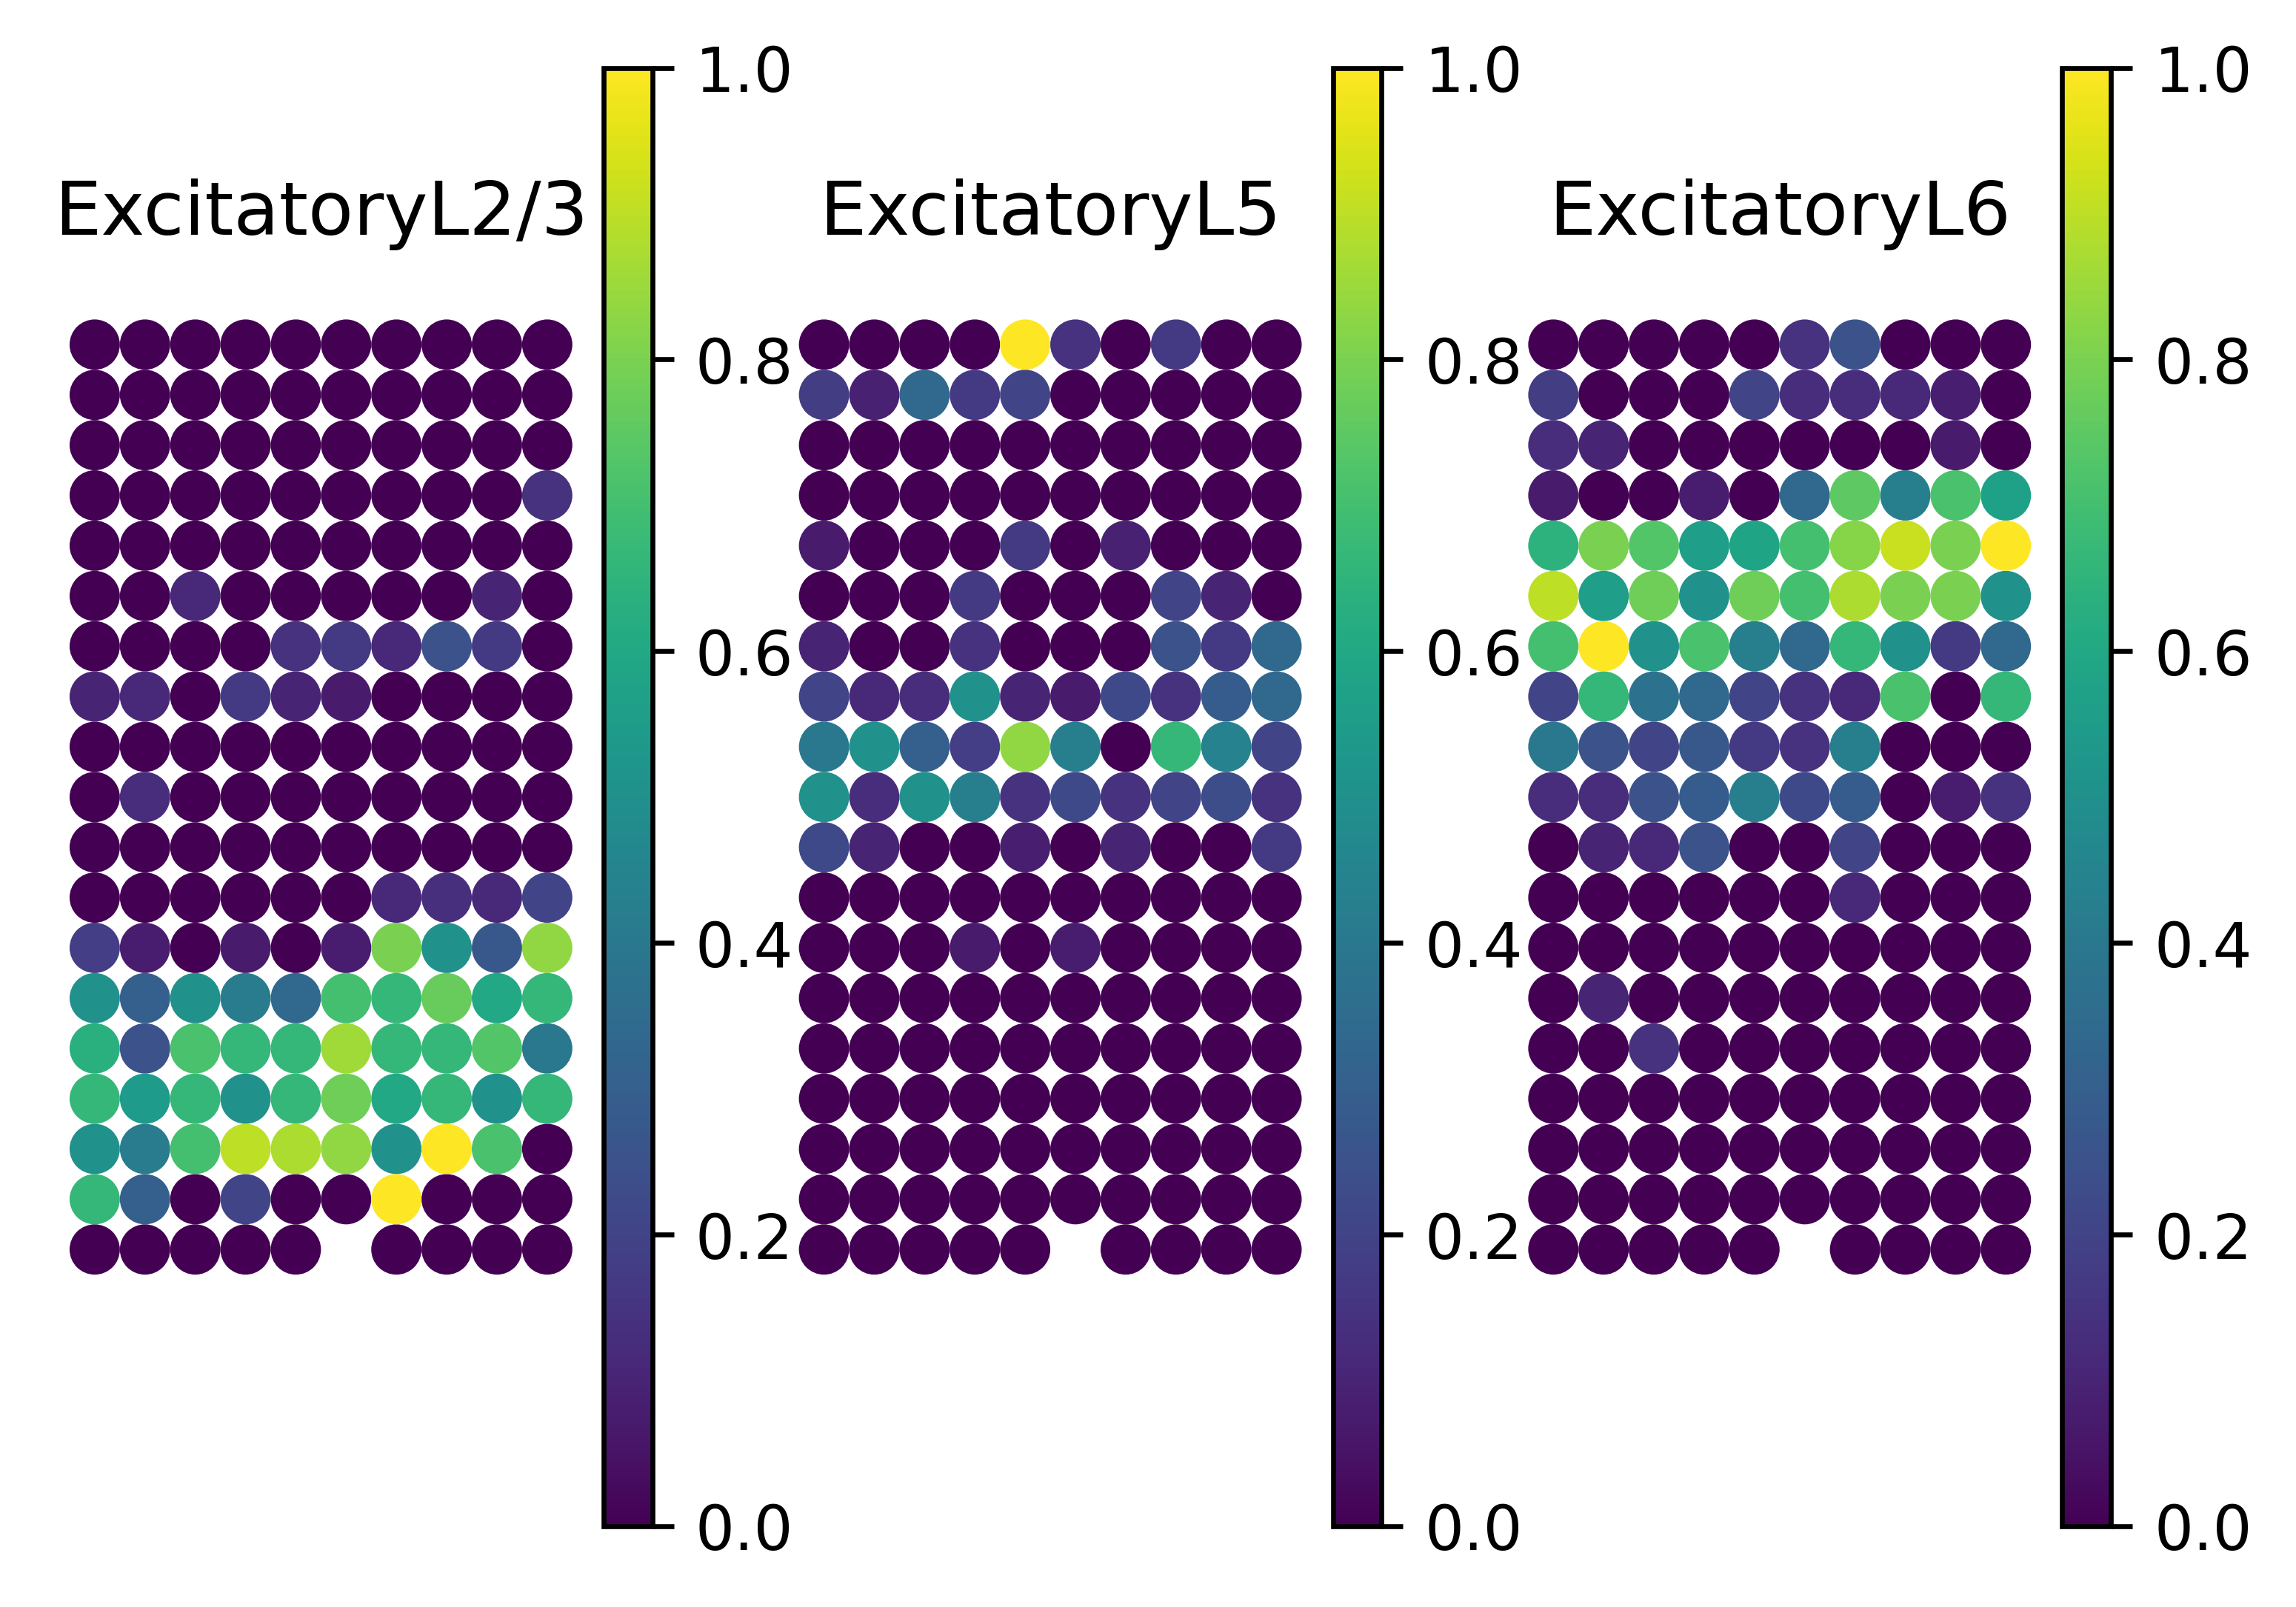

In [6]:
fig, axes = plt.subplots(1, 3, figsize = (6,6), dpi = 600, sharex = True)
sc.pl.spatial(adata_mixture, spot_size = 1, color = 'ExcitatoryL2/3', ncols = 2, frameon = False, ax = axes[0], show = False)
sc.pl.spatial(adata_mixture, spot_size = 1, color = 'ExcitatoryL5', ncols = 2, frameon = False, ax = axes[1], show = False)
sc.pl.spatial(adata_mixture, spot_size = 1, color = 'ExcitatoryL6', ncols = 2, frameon = False, ax = axes[2], show = False)

[<AxesSubplot: title={'center': 'celltype'}, xlabel='spatial1', ylabel='spatial2'>]

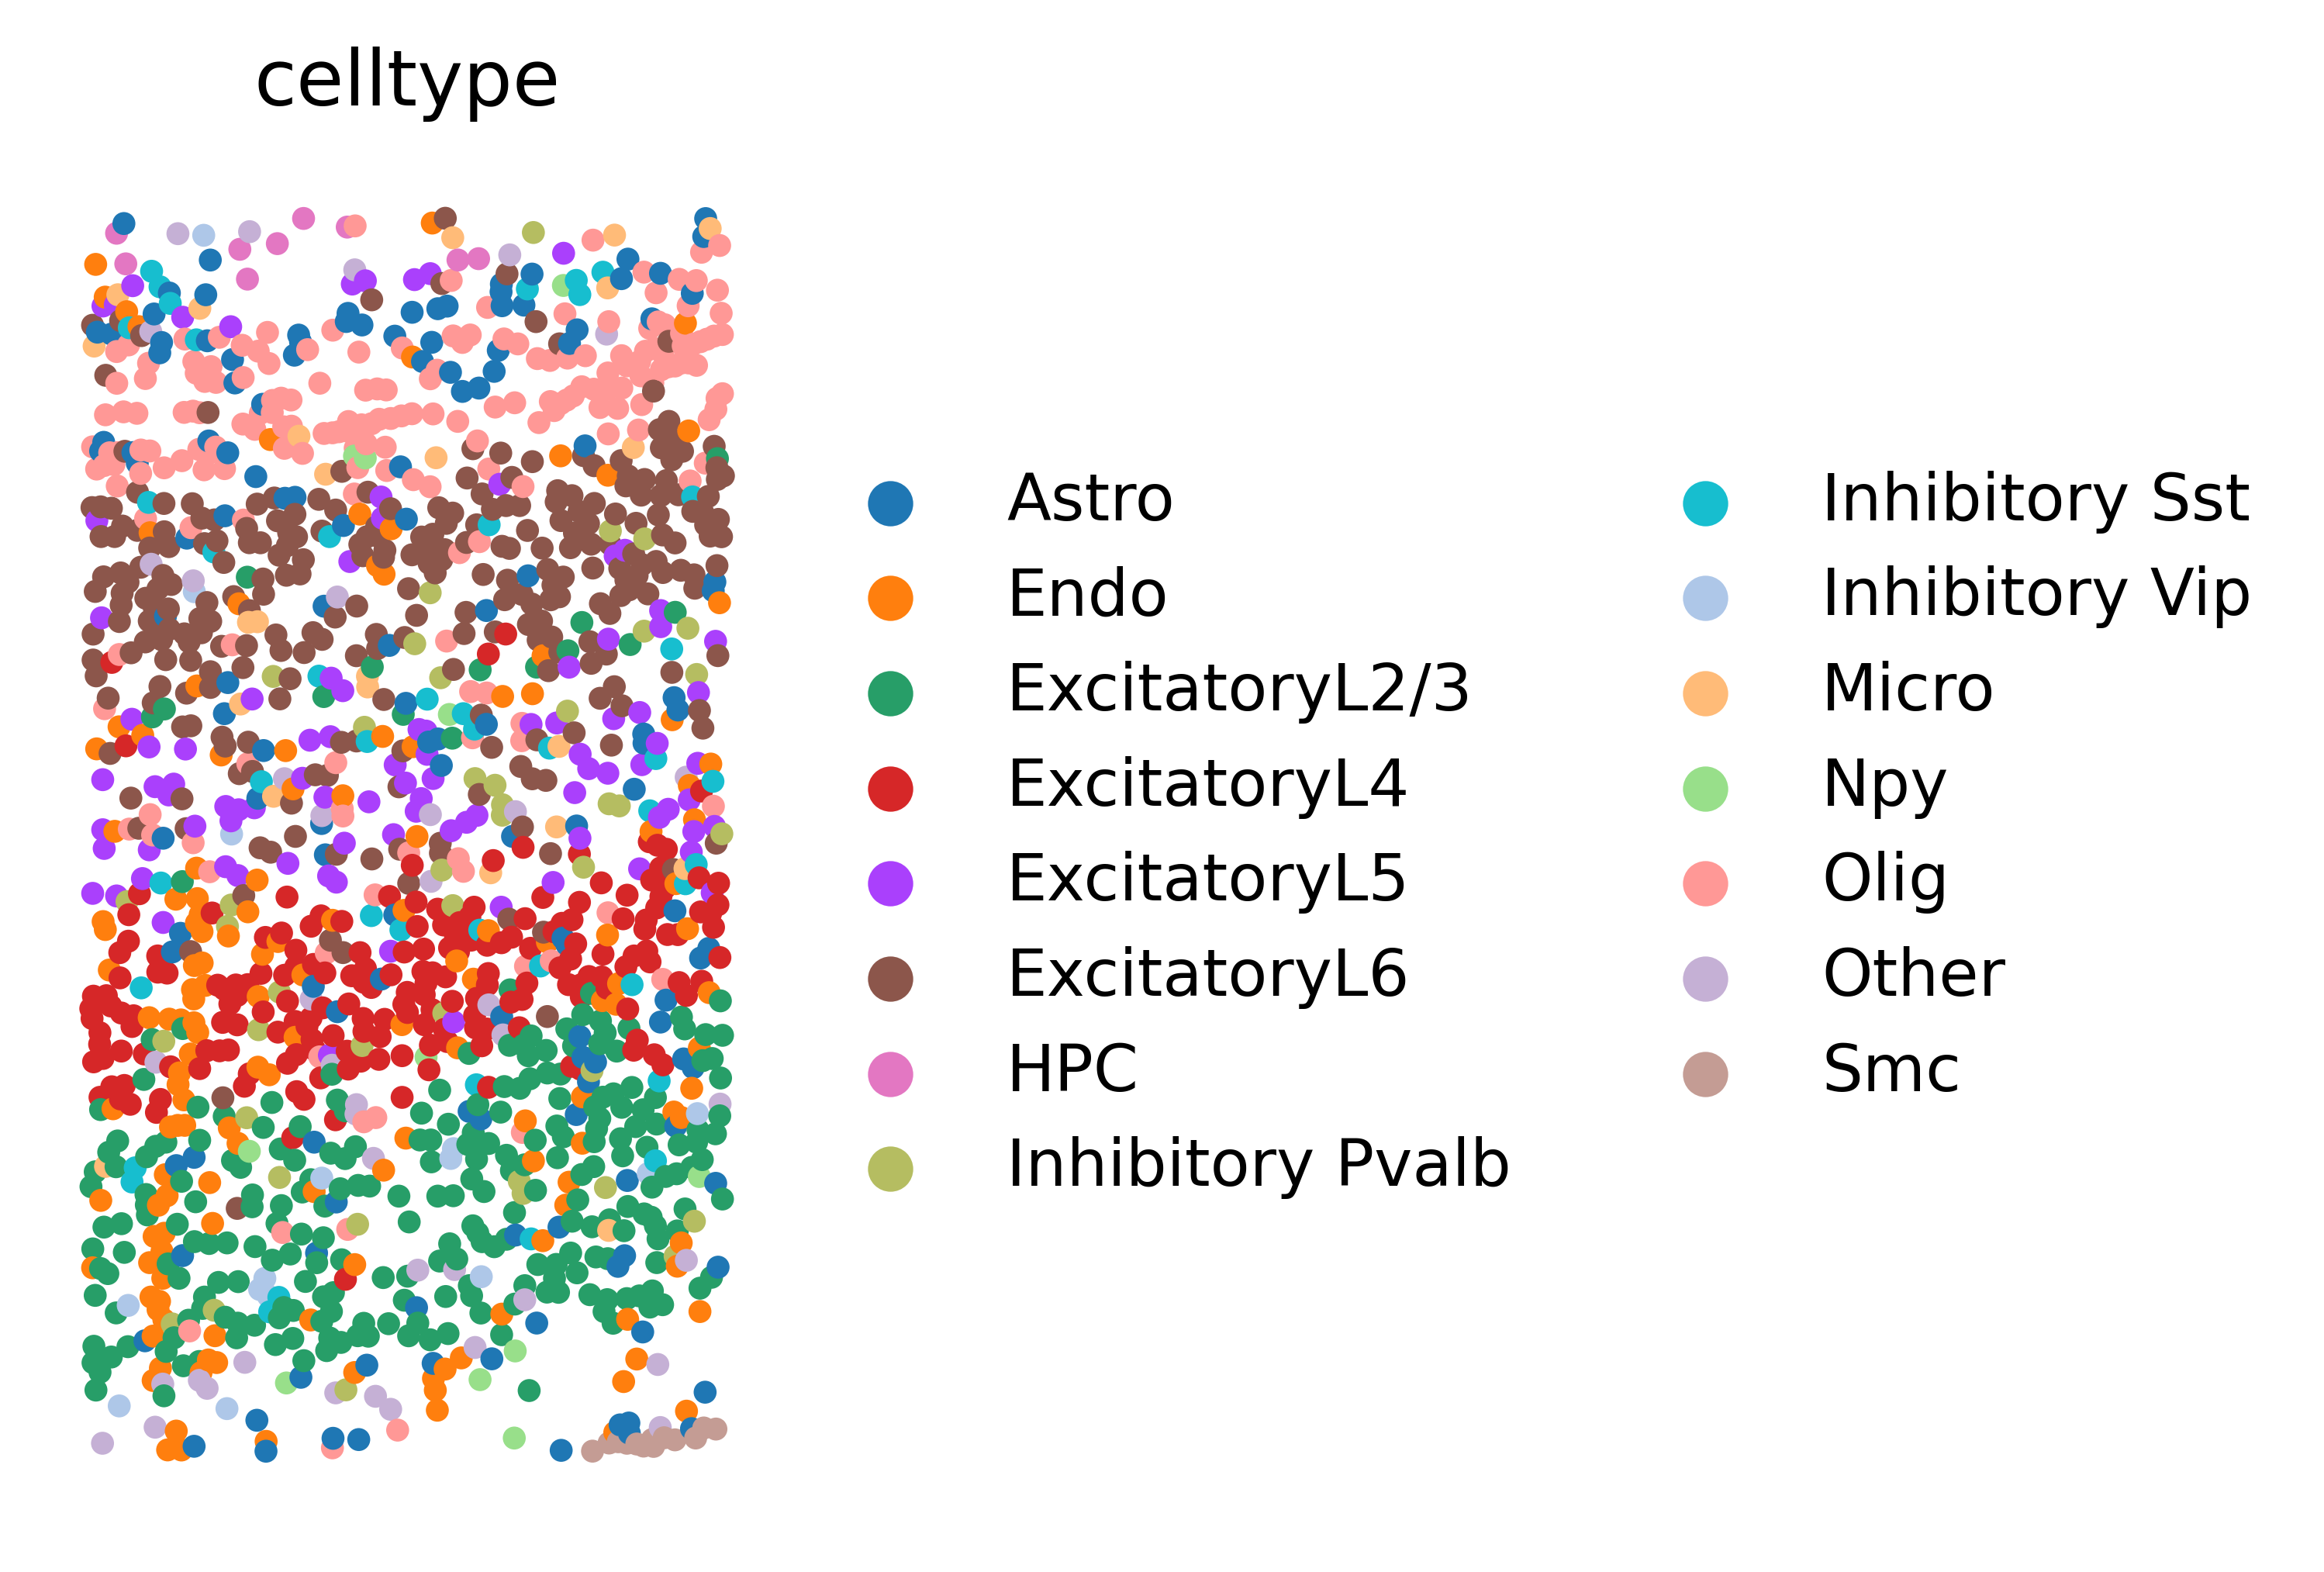

In [7]:
fig, ax = plt.subplots(1, 1, figsize = (2,4), dpi = 600, sharex = True)
sc.pl.spatial(adata_reference, spot_size = 256, color = 'celltype', ncols = 1, show = False, ax = ax,frameon = False)

/tmp/ipykernel_10617/3027137414.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_noucd.method = res_noucd.method.map(naming_remapper)
/tmp/ipykernel_10617/3027137414.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_ucdselect.method = res_ucdselect.method.map(naming_remapper)
/tmp/ipykernel_10617/3027137414.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

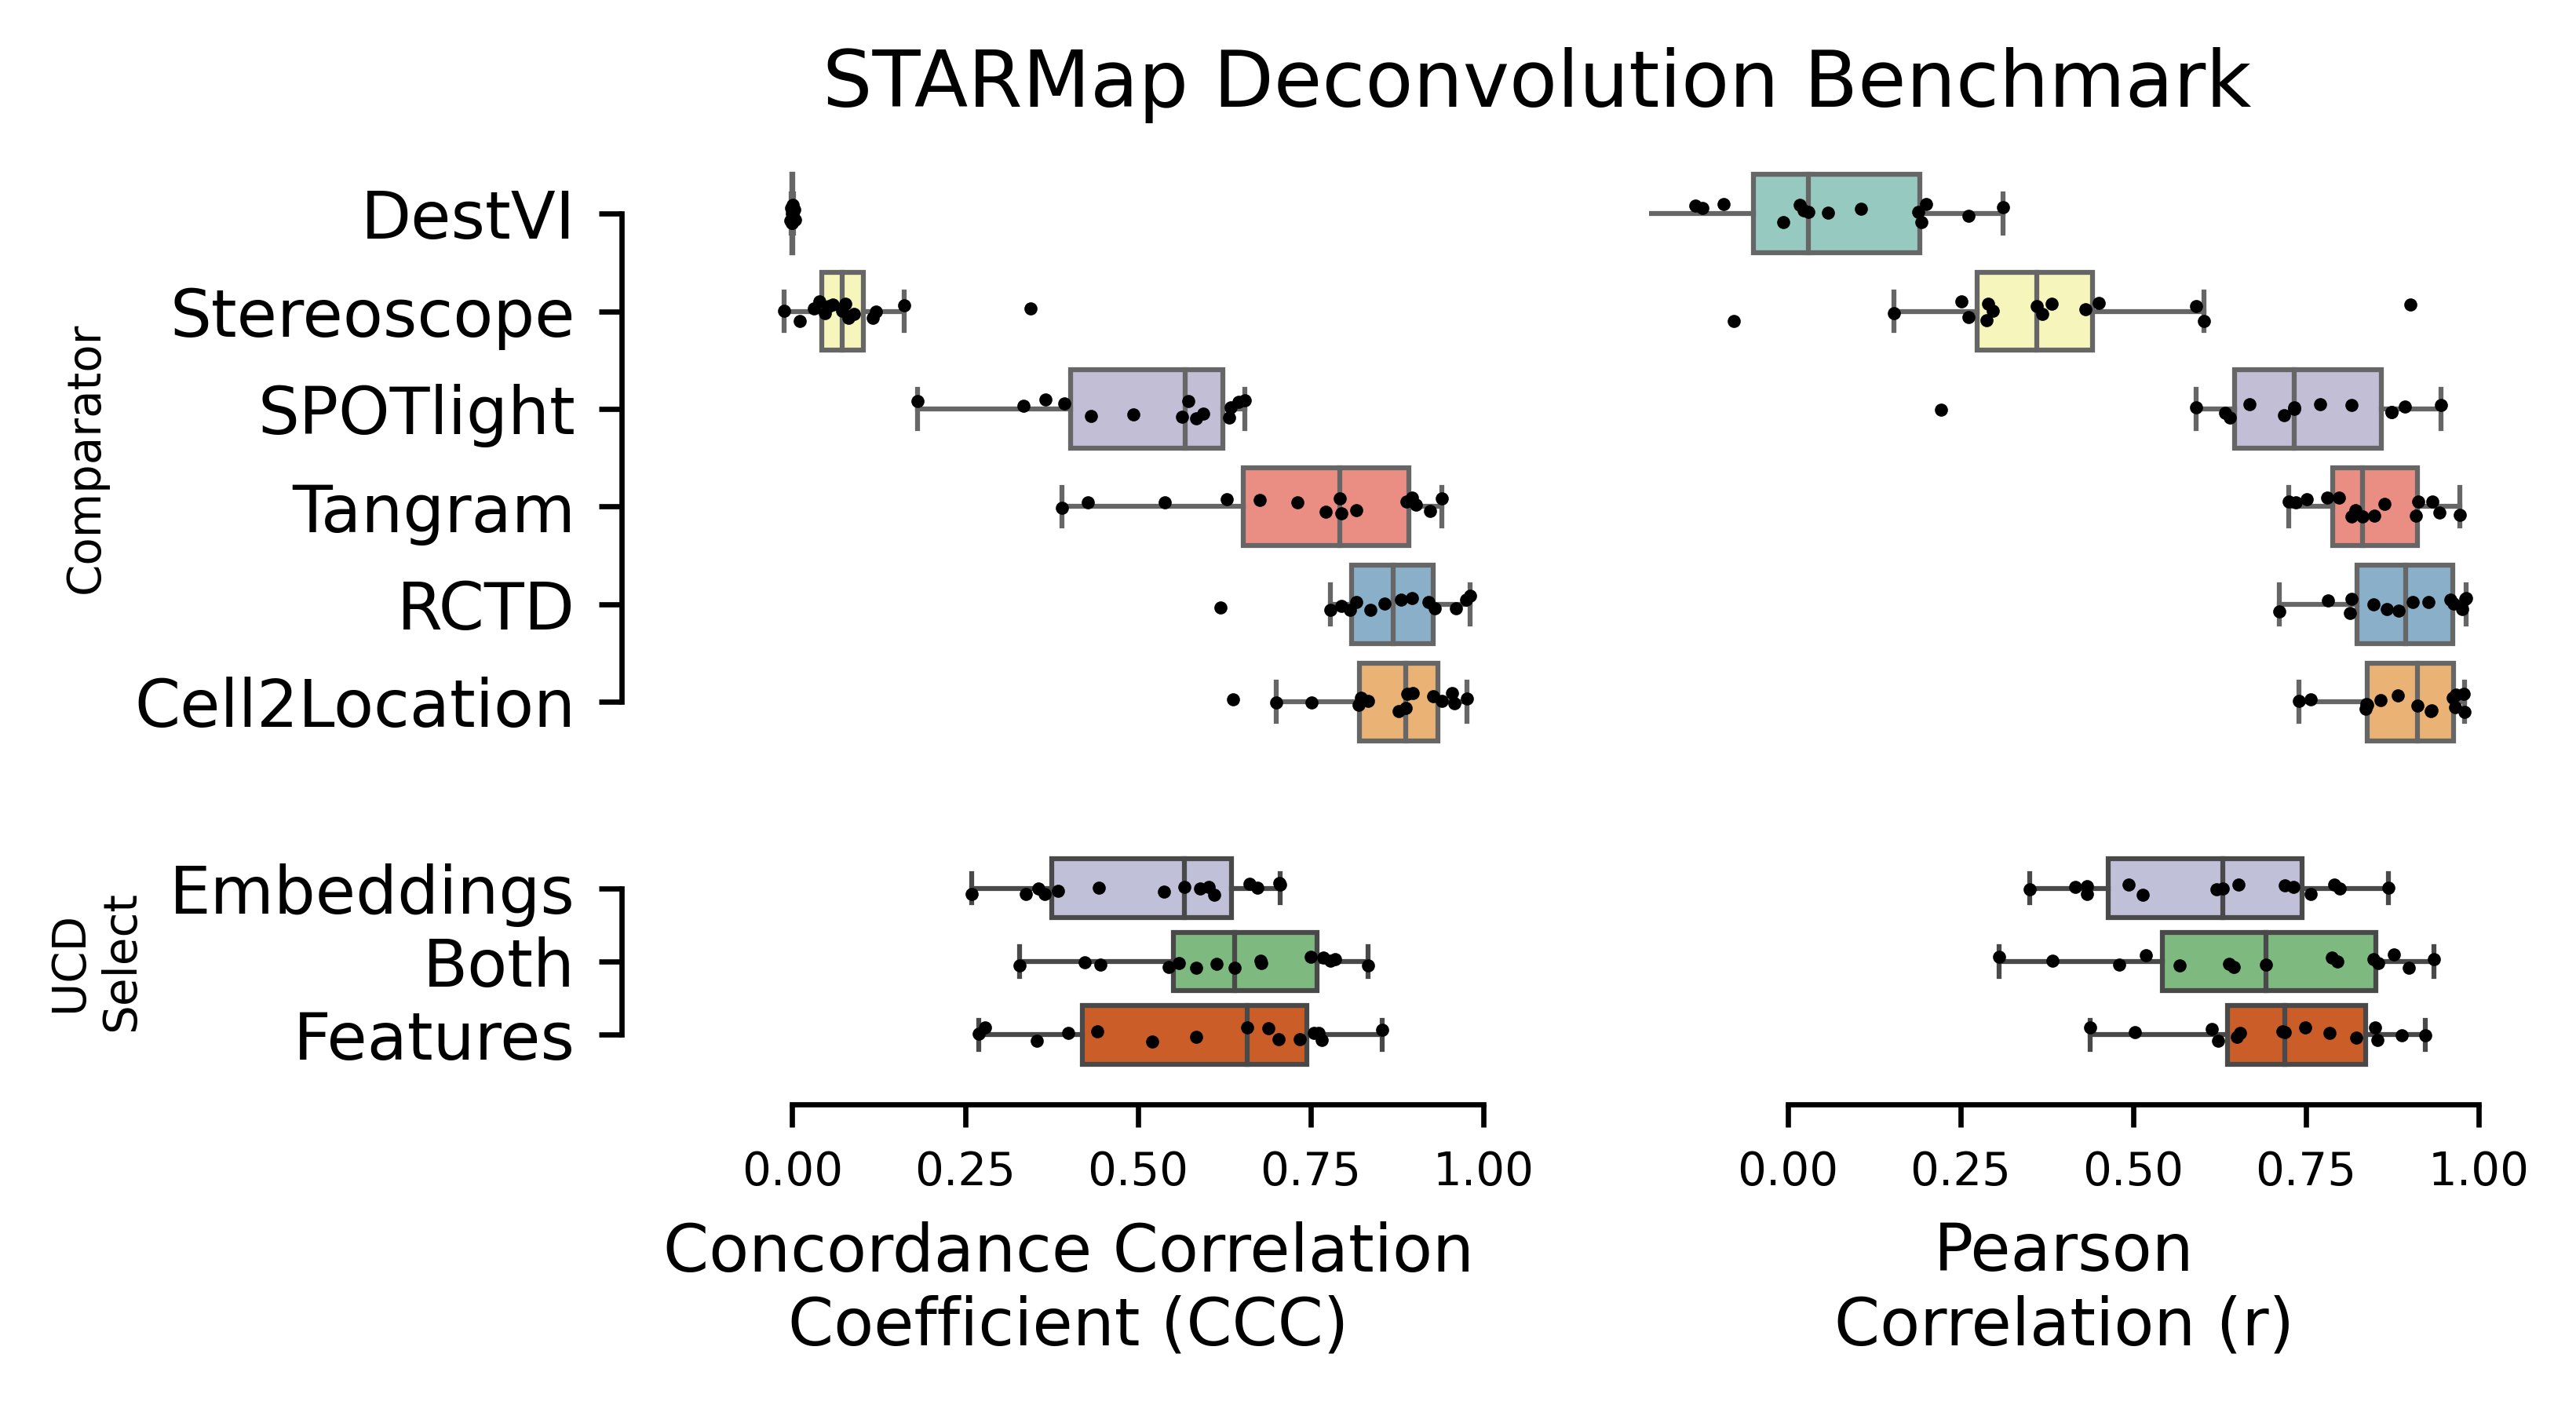

In [18]:
import seaborn as sns
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import textwrap

def trim(ax_i):
    
    xticks = np.asarray(ax_i.get_xticks())
    if xticks.size:
        firsttick = np.compress(xticks >= min(ax_i.get_xlim()),
                                xticks)[0]
        lasttick = np.compress(xticks <= max(ax_i.get_xlim()),
                               xticks)[-1]
        ax_i.spines['bottom'].set_bounds(firsttick, lasttick)
        ax_i.spines['top'].set_bounds(firsttick, lasttick)
        newticks = xticks.compress(xticks <= lasttick)
        newticks = newticks.compress(newticks >= firsttick)
        ax_i.set_xticks(newticks)

    yticks = np.asarray(ax_i.get_yticks())
    if yticks.size:
        firsttick = np.compress(yticks >= min(ax_i.get_ylim()),
                                yticks)[0]
        lasttick = np.compress(yticks <= max(ax_i.get_ylim()),
                               yticks)[-1]
        ax_i.spines['left'].set_bounds(firsttick, lasttick)
        ax_i.spines['right'].set_bounds(firsttick, lasttick)
        newticks = yticks.compress(yticks <= lasttick)
        newticks = newticks.compress(newticks >= firsttick)
        ax_i.set_yticks(newticks)
        

naming_remapper = {
    "stereoscope" : "Stereoscope",
    "cell2location" : "Cell2Location",
    "destvi" : "DestVI",
    "tangram" : "Tangram",
    "ucdselect-features" : "Features",
    "cibersortx" : "CIBERSORTx",
    "spotlight" : "SPOTlight",
    "ucdselect-both" : "Both",
    "rctd" : "RCTD",
    "ucdselect-embeddings" : "Embeddings",
    "ucdbase" : "Base",
    "scdc" : "SCDC",
    "music" : "MuSiC"
}

gs_kw = dict(width_ratios=[1,1], height_ratios=[8,3], hspace=0.25)
fig, axes = plt.subplots(2, 2, figsize = (5,2.5), dpi = 600, sharex = True, sharey = False, gridspec_kw=gs_kw)
axes = axes.T
y = 'method'
x = 'pearsonr'

for i,x in enumerate(['ccc', 'pearsonr']):
    res_noucd = res_all[~res_all.method.str.contains("ucd")]
    res_ucdselect = res_all[res_all.method.str.contains("ucdselect")]

    res_noucd.method = res_noucd.method.map(naming_remapper)
    res_ucdselect.method = res_ucdselect.method.map(naming_remapper)

    order = res_noucd.groupby(y)[x].median().sort_values(ascending = False).index.tolist()[::-1]
    sns.boxplot(data = res_noucd, x = x, y = y, order = order,
             ax = axes[i,0], linewidth = 0.75, palette = 'Set3', fliersize = 0)
    sns.stripplot(data = res_noucd, x = x, y = y, order = order,color = 'k', size = 2, ax = axes[i,0], jitter = True)

    axes[i,0].set_ylabel('Comparator', fontsize = "x-small")
    axes[i,0].set_xlabel('')
    axes[i,0].tick_params(bottom=False)
    axes[i,0].set_xlim(0,1.0)

    for spine in ['bottom', 'right', 'top']:
        axes[i,0].spines[spine].set_visible(False)
    for side in ['left']:
        axes[i,0].spines[side].set_position(('outward', 5))
    trim(axes[i,0])


    order = res_ucdselect.groupby(y)[x].median().sort_values(ascending = False).index.tolist()[::-1]
    sns.boxplot(data = res_ucdselect, x = x, y = y, order = order,
             ax = axes[i,1], linewidth = 0.75, palette = 'tab20c_r', fliersize = 0)
    sns.stripplot(data = res_ucdselect, x = x, y = y, order = order,color = 'k', size = 2, ax = axes[i,1], jitter = True)


    axes[i,1].set_ylabel('UCD\nSelect', fontsize = "x-small")
    axes[i,1].tick_params(bottom=True)
    axes[i,1].set_xlabel('')
    for side in ['right', 'top']:
        axes[i,1].spines[side].set_visible(False)
    for side in ['left', 'bottom']:
        axes[i,1].spines[side].set_position(('outward', 5))
    trim(axes[i,1]) 
    axes[i,1].set_xlim(-0.2,1.0)
    
    
    # Hide things if we are on the right side
    if i == 1:
        for ax in axes[i,:]:
            for side in ['left']:
                ax.spines[side].set_visible(False)
                ax.tick_params(left=False)
                ax.yaxis.set_ticklabels([])
                ax.set_ylabel("")

    axes[0,-1].set_xlabel("Concordance Correlation\nCoefficient (CCC)")
    axes[1,-1].set_xlabel("Pearson\nCorrelation (r)")
    for k in range(0,2): axes[k,-1].tick_params(axis = 'x', which = 'major', labelsize = 'x-small')

    fig.align_ylabels(axes[:,0])
    fig.suptitle("STARMap Deconvolution Benchmark")

# Hippocampus

## Load Data

In [ ]:
# Get base path
basepath = "/home/jupyter/manuscript/figure2/data/additional_benchmarking/hippocampus/"

# Load datasets
adata_reference = sc.read_h5ad(os.path.join(basepath, "adata_hippo_reference_subset.h5ad"))
adata_mixture = sc.read_h5ad(os.path.join(basepath, "adata_hippo_mixture.h5ad"))

# Mixtures undo log transofrm, norm to 10,000 if not already
adata_mixture.X = np.expm1(adata_mixture.X)
sc.pp.normalize_total(adata_mixture, 1e4)

# Reference undo log transofrm, norm to 10,000 if not already
adata_reference.X = np.expm1(adata_reference.X)
sc.pp.normalize_total(adata_mixture, 1e4)

# Subet top 7,000 genes only to reduce computational overhead
adata_reference.layers["counts"] = adata_reference.X.copy()
sc.pp.highly_variable_genes(adata_reference, n_top_genes = 7000, subset=True, layer="counts", flavor="seurat_v3", span = 1)

# Intersect common genes
intersect = np.intersect1d(adata_mixture.var_names, adata_reference.var_names)
adata_mixture = adata_mixture[:, intersect]
adata_reference = adata_reference[:, intersect]

# Only keep known references
adata_reference = adata_reference[adata_reference.obs.celltype.ne('unknown')]

# Make explicit copies
adata_reference = adata_reference.copy()
adata_mixture = adata_mixture.copy()

# Setup layers
adata_reference.X = adata_reference.X.astype(np.int32)
adata_reference.layers["counts"] = adata_reference.layers["counts"].astype(np.int32)

adata_mixture.layers["counts"] = adata_mixture.X.copy()
adata_mixture.X = adata_mixture.X.astype(np.int32)
adata_mixture.layers["counts"] = adata_mixture.layers["counts"].astype(np.int32)

## Run Deconvolution

### Stereoscope

In [ ]:
RNAStereoscope.setup_anndata(adata_reference, layer = "counts", labels_key = "celltype")

reference_model = RNAStereoscope(adata_reference)
reference_model.train(max_epochs = 100)
reference_model.history["elbo_train"][10:].plot()
reference_model.save("reference_model", overwrite=True)

In [ ]:
RNAStereoscope.setup_anndata(adata_mixture, layer="counts")

mixture_model = SpatialStereoscope.from_rna_model(adata_mixture, reference_model)
mixture_model.train(max_epochs = 3000)
mixture_model.history["elbo_train"][10:].plot()
mixture_model.save("mixture_model", overwrite = True)

In [ ]:
celltype_preds_mixture_stereoscope = mixture_model.get_proportions()
celltype_preds_mixture_stereoscope = (celltype_preds_mixture_stereoscope.T / celltype_preds_mixture_stereoscope.T.sum(0)).T

preds = celltype_preds_mixture_stereoscope
common_celltypes = list(set(adata_mixture.obs.columns).intersection(set(preds.columns)))
res = pd.DataFrame([[c, ccc(adata_mixture.obs[c].values, preds[c].values)[0], pearsonr(adata_mixture.obs[c].values, preds[c].values)[0]] \
                        for c in common_celltypes],columns = ['celltype', 'ccc','pearsonr']).set_index('celltype')

preds.to_csv("/home/jupyter/manuscript/figure2/data/additional_benchmarking/hippocampus/results/preds_hippocampus_stereoscope.csv", sep = ",")
print(res.round(2), res.mean(),res.std())

### Tangram

In [ ]:
import tangram as tg
import time

start = time.time()
tg.pp_adatas(adata_reference, adata_mixture)
ad_map = tg.map_cells_to_space(adata_reference, adata_mixture, mode='clusters', cluster_label="celltype")
tg.project_cell_annotations(ad_map, adata_mixture, annotation = "celltype")
tangram_preds = (adata_mixture.obsm['tangram_ct_pred'].T / adata_mixture.obsm['tangram_ct_pred'].T.sum(0)).T
end = time.time()
print(end - start)

In [ ]:
preds = tangram_preds
common_celltypes = list(set(adata_mixture.obs.columns).intersection(set(preds.columns)))
res = pd.DataFrame([[c, ccc(adata_mixture.obs[c].values, preds[c].values)[0], pearsonr(adata_mixture.obs[c].values, preds[c].values)[0]] \
                        for c in common_celltypes],columns = ['celltype', 'ccc','pearsonr']).set_index('celltype')
preds.to_csv("/home/jupyter/manuscript/figure2/data/additional_benchmarking/hippocampus/results/preds_hippocampus_tangram.csv", sep = ",")
print(res.round(2), res.mean(),res.std())

### DestVI

In [ ]:
adata_reference_sub = adata_reference[np.random.choice(len(adata_reference), 5000, replace = False)].copy()

In [ ]:
from scvi.model import CondSCVI, DestVI

CondSCVI.setup_anndata(adata_reference_sub, layer="counts", labels_key="celltype")
reference_model_destvi = CondSCVI(adata_reference_sub, weight_obs=True)

reference_model_destvi.train(max_epochs=1000)
reference_model_destvi.history["elbo_train"][10:].plot()

In [ ]:
DestVI.setup_anndata(adata_mixture, layer="counts")
mixture_model_destvi = DestVI.from_rna_model(adata_mixture, reference_model_destvi)
mixture_model_destvi.train(max_epochs=2500)
mixture_model_destvi.history["elbo_train"][10:].plot()

In [ ]:
celltype_preds_mixture_destvi = mixture_model_destvi.get_proportions()
celltype_preds_mixture_destvi = (celltype_preds_mixture_destvi.T / celltype_preds_mixture_destvi.T.sum(0)).T

preds = celltype_preds_mixture_destvi
common_celltypes = list(set(adata_mixture.obs.columns).intersection(set(preds.columns)))

res = pd.DataFrame([[c, ccc(adata_mixture.obs[c].values, preds[c].values)[0], pearsonr(adata_mixture.obs[c].values, preds[c].values)[0]] \
                        for c in common_celltypes],columns = ['celltype', 'ccc','pearsonr']).set_index('celltype')
preds.to_csv("/home/jupyter/manuscript/figure2/data/additional_benchmarking/hippocampus/results/preds_hippocampus_destvi.csv", sep = ",")
print(res.round(2), res.mean(),res.std())

### Cell2Location

In [ ]:
import cell2location
from cell2location.models import RegressionModel

In [ ]:
# Prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_reference, labels_key='celltype')

# Create Regression Model
mod = RegressionModel(adata_reference)

# Train the Regression Model
mod.train(max_epochs=2000, use_gpu=True)

In [ ]:
# Let's check our model output to make sure the training curve looks good
mod.plot_history(20)

In [ ]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_reference = mod.export_posterior(adata_reference, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True})
mod.plot_QC()

In [ ]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_reference.varm.keys():
    inf_aver = adata_reference.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_reference.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_reference.var[[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_reference.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_reference.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

In [ ]:
# Setup anndata object for mixture
cell2location.models.Cell2location.setup_anndata(adata=adata_mixture)

# create and train the model
mod = cell2location.models.Cell2location(
    adata_mixture, cell_state_df=inf_aver,
    N_cells_per_location=5,
    detection_alpha=20
)
mod.view_anndata_setup()

In [ ]:
mod.train(max_epochs=8000,
          batch_size=None,
          train_size=1,
          use_gpu=True)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [ ]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_mixture = mod.export_posterior(adata_mixture, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True})

# Examine reconstruction accuracy to assess if there are any issues with mapping
# the plot should be roughly diagonal, strong deviations will signal problems
mod.plot_QC()

In [ ]:
celltype_preds_mixture = adata_mixture.obsm['q05_cell_abundance_w_sf'].copy()
celltype_preds_mixture.columns = celltype_preds_mixture.columns.str[23:]
celltype_preds_mixture = (celltype_preds_mixture.T / celltype_preds_mixture.T.sum(0)).T

preds = celltype_preds_mixture
common_celltypes = list(set(adata_mixture.obs.columns).intersection(set(preds.columns)))
res = pd.DataFrame([[c, ccc(adata_mixture.obs[c].values, preds[c].values)[0], pearsonr(adata_mixture.obs[c].values, preds[c].values)[0]] \
                        for c in common_celltypes],columns = ['celltype', 'ccc','pearsonr']).set_index('celltype')
preds.to_csv("/home/jupyter/manuscript/figure2/data/additional_benchmarking/hippocampus/results/preds_hippocampus_cell2location.csv", sep = ",")
print(res, res.mean(),res.std())

### RCTD

In [ ]:
########### RCTD ######################
# Write a copy as a dge matrix
adata_reference.to_df().T.to_csv(os.path.join(basepath, "adata_hippo_reference_R.csv"))

# WRite metadata about each cluster
meta_data = pd.Series(adata_reference.obs.celltype.values).to_frame()
meta_data.columns = ['cluster']
meta_data.index.name = 'barcode'
meta_data['nUMI'] = np.array(adata_reference.X.sum(1)).flatten()
meta_data = meta_data.reset_index()
meta_data.to_csv(os.path.join(basepath, "adata_hippo_reference_R_metadata.csv"))

# Cell type infor about each cluster
cell_type_dict = pd.Series(dict(zip(adata_reference.obs.celltype.cat.codes,
         adata_reference.obs.celltype.astype(str)))).reset_index()
cell_type_dict.columns = ['cluster', 'name']
cell_type_dict.to_csv(os.path.join(basepath, "adata_hippo_reference_R-cell_type_dict.csv"))

In [ ]:
adata_mixture.to_df().T.to_csv(os.path.join(basepath, "adata_hippo_mixture_R.csv"))
mixture_coords = pd.DataFrame(np.random.randint(0,10000, (len(adata_mixture), 2)), index = adata_mixture.obs_names)
mixture_coords.columns = ['xcoord', 'ycoord']
mixture_coords.to_csv(os.path.join(basepath, "adata_hippo_mixture_R-coords.csv"))

## Plot Results

In [ ]:
import glob
from scipy.stats import pearsonr

basepath = "/home/jupyter/manuscript/figure2/data/additional_benchmarking/hippocampus/"

res_all = []
for f in glob.glob(os.path.join(basepath,"results/*.csv")):
    res = pd.read_csv(f)
    res.columns = res.columns.str.replace("_"," ")
    res = res.T.loc[~res.columns.str.startswith("Unnamed")].T
    res = res.reindex(columns = adata_mixture.obs.columns)
    
    method = f.rsplit("_",1)[-1].split(".",1)[0].lower()
    
    for celltype in adata_mixture.obs.columns:
        try:
            val_pearsonr, pval = pearsonr(adata_mixture.obs[celltype], res[celltype])
            val_ccc, _ = ccc(adata_mixture.obs[celltype], res[celltype])
        except:
            continue
        
        res_all.append([method, celltype, val_pearsonr, val_ccc, pval])
    
    #res = res.unstack().reset_index()
    #res.columns = ['celltype','mixture','pred']
    #res['method'] = f.rsplit("_",1)[-1].split(".",1)[0]
    
    #res_all.append(res)
res_all = pd.DataFrame(res_all, columns = ['method','celltype', 'pearsonr', 'ccc','pval'])

naming_remapper = {
    "stereoscope" : "Stereoscope",
    "cell2location" : "Cell2Location",
    "destvi" : "DestVI",
    "tangram" : "Tangram",
    "ucdselect-features" : "UCDSelect-Features",
    "cibersortx" : "CIBERSORTx",
    "spotlight" : "SPOTlight",
    "ucdselect-both" : "UCDSelect-Both",
    "rctd" : "RCTD",
    "ucdselect-embeddings" : "UCDSelect-Embeddings",
    "ucdbase" : "Base",
    "scdc" : "SCDC",
    "music" : "MuSiC"
}

In [ ]:
res_all.groupby('method')[['ccc','pearsonr']].mean()

In [ ]:
import seaborn as sns
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import textwrap

gs_kw = dict(width_ratios=[1], height_ratios=[8,4])
fig, ax = plt.subplots(1, 1, figsize = (4,2), dpi = 300, sharex = True)

res_all.method = res_all.method.map(naming_remapper)
order = res_all.groupby("method").ccc.median().sort_values(ascending = False).index.tolist()
y = 'method'
x = 'ccc'

#sns.barplot(data = res_all, x = x, y = y, order = order,
#         ax = ax, linewidth = 1, palette = 'Set3', alpha = 0.5, errwidth=0)
sns.boxplot(data = res_all, x = x, y = y, order = order, width = 0.65,
               ax = ax, linewidth = 0.75, fliersize = 0.0, palette = 'Set3')
sns.stripplot(data = res_all, x = x, y = y, order = order,
              color = 'k', size = 2, ax = ax, jitter = True)

ax.set_xlim(-0.1, 1.1)
#axes[0].hlines(0, -0.500025, 8.5, linestyle = "--", color = "k", linewidth = 0.75)
ax.set_ylabel('Method')
ax.set_xlabel('Concordance Correlation\nCoefficient (CCC)')
#ax.spines['bottom'].set_visible(False)
ax.tick_params(bottom=True)
ax.set_ylabel('')

plt.tight_layout()
sns.despine(trim = True, offset = 5)
ax.spines['bottom'].set_visible(True)
#plt.title("Hippocampus Deconvolution")


# PBMC

## Load & Preprocess Data

In [ ]:
# Get base path
basepath = "/home/jupyter/manuscript/figure2/data/pp/"

# Load datasets
adata_reference = sc.read_h5ad(os.path.join(basepath, "adata_pbmc_5k_pp_annots.h5ad"))
adata_mixture = sc.read_h5ad(os.path.join(basepath, "adata_pbmc_10k_pp_MIXTURE_c5_s100_n500_d0.h5ad"))

# Mixtures undo log transofrm, norm to 10,000 if not already
adata_mixture.X = np.expm1(adata_mixture.X)
sc.pp.normalize_total(adata_mixture, 1e4)

# Reference undo log transofrm, norm to 10,000 if not already
adata_reference.X = np.expm1(adata_reference.X)
sc.pp.normalize_total(adata_mixture, 1e4)

# Subet top 7,000 genes only to reduce computational overhead
adata_reference.layers["counts"] = adata_reference.X.copy()
sc.pp.highly_variable_genes(adata_reference, n_top_genes = 7000, subset=True, layer="counts", flavor="seurat_v3", span = 1)

# Intersect common genes
intersect = np.intersect1d(adata_mixture.var_names, adata_reference.var_names)
adata_mixture = adata_mixture[:, intersect]
adata_reference = adata_reference[:, intersect]

# Only keep known references
adata_reference = adata_reference[adata_reference.obs.celltype.ne('unknown')]

# Make explicit copies
adata_reference = adata_reference.copy()
adata_mixture = adata_mixture.copy()

# Setup layers
adata_reference.X = adata_reference.X.astype(np.int32)
adata_reference.layers["counts"] = adata_reference.layers["counts"].astype(np.int32)

adata_mixture.layers["counts"] = adata_mixture.X.copy()
adata_mixture.X = adata_mixture.X.astype(np.int32)
adata_mixture.layers["counts"] = adata_mixture.layers["counts"].astype(np.int32)

## RCTD

In [ ]:
########### RCTD ######################
# Write a copy as a dge matrix
adata_reference.to_df().T.to_csv(os.path.join(basepath, "adata_PBMC_reference_R.csv"))

# WRite metadata about each cluster
meta_data = pd.Series(adata_reference.obs.celltype.values).to_frame()
meta_data.columns = ['cluster']
meta_data.index.name = 'barcode'
meta_data['nUMI'] = np.array(adata_reference.X.sum(1)).flatten()
meta_data = meta_data.reset_index()
meta_data.to_csv(os.path.join(basepath, "adata_PBMC_reference_R_metadata.csv"))

# Cell type infor about each cluster
cell_type_dict = pd.Series(dict(zip(adata_reference.obs.celltype.cat.codes,
         adata_reference.obs.celltype.astype(str)))).reset_index()
cell_type_dict.columns = ['cluster', 'name']
cell_type_dict.to_csv(os.path.join(basepath, "adata_PBMC_reference_R-cell_type_dict.csv"))

In [ ]:
adata_mixture.to_df().T.to_csv(os.path.join(basepath, "adata_PBMC_mixture_R.csv"))
mixture_coords = pd.DataFrame(np.random.randint(0,10000, (len(adata_mixture), 2)), index = adata_mixture.obs_names)
mixture_coords.columns = ['xcoord', 'ycoord']
mixture_coords.to_csv(os.path.join(basepath, "adata_PBMC_mixture_R-coords.csv"))

## Plot Results

In [ ]:
basepath = "/home/jupyter/manuscript/figure2/data/external_deconv_results"
common_celltypes = list(set(adata_reference.obs.celltype))

In [ ]:
import glob

In [ ]:
fnames = glob.glob(os.path.join(basepath,"*.tsv")) + glob.glob(os.path.join(basepath,"*.csv"))
fnames = [x for x in fnames if not (("MUSIC_old" in x) or ("LM22" in x))]

In [ ]:
res_all = []
for fname in fnames:
    method = fname.rsplit("_",1)[-1].split(".")[0].lower()
    print(method)
    res = pd.read_table(fname, sep = "\t" if fname.endswith(".tsv") else ",")
    res.columns = res.columns.str.replace("_"," ").str.replace(" positive", "-positive,").str.replace("alpha beta","alpha-beta")
    res = res.reindex(columns = common_celltypes)
    
    for celltype in adata_mixture.obs.columns:
            try:
                val_pearsonr, pval = pearsonr(adata_mixture.obs[celltype], res[celltype])
                val_ccc, _ = ccc(adata_mixture.obs[celltype], res[celltype])
            except:
                continue

            res_all.append([method, celltype, val_pearsonr, val_ccc, pval])
res_all = pd.DataFrame(res_all, columns = ['method','celltype', 'pearsonr', 'ccc','pval'])

In [ ]:
res_all.groupby('method')[['ccc','pearsonr']].mean().to_csv("res_merged_pbmc.csv")

In [ ]:
naming_remapper = {
    "stereoscope" : "Stereoscope",
    "cell2location" : "Cell2Location",
    "destvi" : "DestVI",
    "tangram" : "Tangram",
    "ucdselect-features" : "Features",
    "cibersortx" : "CIBERSORTx",
    "spotlight" : "SPOTlight",
    "ucdselect-both" : "Both",
    "rctd" : "RCTD",
    "ucdselect-embeddings" : "Embeddings",
    "ucdbase" : "Base",
    "scdc" : "SCDC",
    "music" : "MuSiC"
}

In [ ]:
def trim(ax_i):
    
    xticks = np.asarray(ax_i.get_xticks())
    if xticks.size:
        firsttick = np.compress(xticks >= min(ax_i.get_xlim()),
                                xticks)[0]
        lasttick = np.compress(xticks <= max(ax_i.get_xlim()),
                               xticks)[-1]
        ax_i.spines['bottom'].set_bounds(firsttick, lasttick)
        ax_i.spines['top'].set_bounds(firsttick, lasttick)
        newticks = xticks.compress(xticks <= lasttick)
        newticks = newticks.compress(newticks >= firsttick)
        ax_i.set_xticks(newticks)

    yticks = np.asarray(ax_i.get_yticks())
    if yticks.size:
        firsttick = np.compress(yticks >= min(ax_i.get_ylim()),
                                yticks)[0]
        lasttick = np.compress(yticks <= max(ax_i.get_ylim()),
                               yticks)[-1]
        ax_i.spines['left'].set_bounds(firsttick, lasttick)
        ax_i.spines['right'].set_bounds(firsttick, lasttick)
        newticks = yticks.compress(yticks <= lasttick)
        newticks = newticks.compress(newticks >= firsttick)
        ax_i.set_yticks(newticks)

In [ ]:
import seaborn as sns
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import textwrap

def trim(ax_i):
    
    xticks = np.asarray(ax_i.get_xticks())
    if xticks.size:
        firsttick = np.compress(xticks >= min(ax_i.get_xlim()),
                                xticks)[0]
        lasttick = np.compress(xticks <= max(ax_i.get_xlim()),
                               xticks)[-1]
        ax_i.spines['bottom'].set_bounds(firsttick, lasttick)
        ax_i.spines['top'].set_bounds(firsttick, lasttick)
        newticks = xticks.compress(xticks <= lasttick)
        newticks = newticks.compress(newticks >= firsttick)
        ax_i.set_xticks(newticks)

    yticks = np.asarray(ax_i.get_yticks())
    if yticks.size:
        firsttick = np.compress(yticks >= min(ax_i.get_ylim()),
                                yticks)[0]
        lasttick = np.compress(yticks <= max(ax_i.get_ylim()),
                               yticks)[-1]
        ax_i.spines['left'].set_bounds(firsttick, lasttick)
        ax_i.spines['right'].set_bounds(firsttick, lasttick)
        newticks = yticks.compress(yticks <= lasttick)
        newticks = newticks.compress(newticks >= firsttick)
        ax_i.set_yticks(newticks)
        

naming_remapper = {
    "stereoscope" : "Stereoscope",
    "cell2location" : "Cell2Location",
    "destvi" : "DestVI",
    "tangram" : "Tangram",
    "ucdselect-features" : "Features",
    "cibersortx" : "CIBERSORTx",
    "spotlight" : "SPOTlight",
    "ucdselect-both" : "Both",
    "rctd" : "RCTD",
    "ucdselect-embeddings" : "Embeddings",
    "ucdbase" : "Base",
    "scdc" : "SCDC",
    "music" : "MuSiC"
}

gs_kw = dict(width_ratios=[1,1], height_ratios=[8,1,3], hspace=0.25)
fig, axes = plt.subplots(3, 2, figsize = (5,2.5), dpi = 600, sharex = True, sharey = False, gridspec_kw=gs_kw)
axes = axes.T
y = 'method'
x = 'pearsonr'

for i,x in enumerate(['ccc', 'pearsonr']):
    res_noucd = res_all[~res_all.method.str.contains("ucd")]
    res_ucdbase = res_all[res_all.method.str.contains("ucdbase")]
    res_ucdselect = res_all[res_all.method.str.contains("ucdselect")]

    res_noucd.method = res_noucd.method.map(naming_remapper)
    res_ucdbase.method = res_ucdbase.method.map(naming_remapper)
    res_ucdselect.method = res_ucdselect.method.map(naming_remapper)

    order = res_noucd.groupby(y)[x].median().sort_values(ascending = False).index.tolist()[::-1]
    sns.boxplot(data = res_noucd, x = x, y = y, order = order,
             ax = axes[i,0], linewidth = 0.75, palette = 'Set3', fliersize = 0)
    sns.stripplot(data = res_noucd, x = x, y = y, order = order,color = 'k', size = 2, ax = axes[i,0], jitter = True)

    axes[i,0].set_ylabel('Comparator', fontsize = "x-small")
    axes[i,0].set_xlabel('')
    axes[i,0].tick_params(bottom=False)
    axes[i,0].set_xlim(0,1.0)

    for spine in ['bottom', 'right', 'top']:
        axes[i,0].spines[spine].set_visible(False)
    for side in ['left']:
        axes[i,0].spines[side].set_position(('outward', 5))
    trim(axes[i,0])

    order = res_ucdbase.groupby(y)[x].median().sort_values(ascending = False).index.tolist()[::-1]
    sns.boxplot(data = res_ucdbase, x = x, y = y, order = order,
             ax = axes[i,1], linewidth = 0.75, palette = 'tab10', fliersize = 0)
    sns.stripplot(data = res_ucdbase, x = x, y = y, order = order,color = 'k', size = 2, ax = axes[i,1], jitter = True)

    axes[i,1].set_ylabel('UCD',  fontsize = "x-small")
    axes[i,1].tick_params(bottom=False)
    axes[i,1].set_xlabel('')
    for spine in ['bottom', 'right', 'top']:
        axes[i,1].spines[spine].set_visible(False)
    for side in ['left']:
        axes[i,1].spines[side].set_position(('outward', 5))
    trim(axes[i,1])


    order = res_ucdselect.groupby(y)[x].median().sort_values(ascending = False).index.tolist()[::-1]
    sns.boxplot(data = res_ucdselect, x = x, y = y, order = order,
             ax = axes[i,2], linewidth = 0.75, palette = 'tab20c_r', fliersize = 0)
    sns.stripplot(data = res_ucdselect, x = x, y = y, order = order,color = 'k', size = 2, ax = axes[i,2], jitter = True)


    axes[i,2].set_ylabel('UCD\nSelect', fontsize = "x-small")
    axes[i,2].tick_params(bottom=True)
    axes[i,2].set_xlabel('')
    for side in ['right', 'top']:
        axes[i,2].spines[side].set_visible(False)
    for side in ['left', 'bottom']:
        axes[i,2].spines[side].set_position(('outward', 5))
    trim(axes[i,2]) 
    axes[i,2].set_xlim(0,1.0)
    
    
    # Hide things if we are on the right side
    if i == 1:
        for ax in axes[i,:]:
            for side in ['left']:
                ax.spines[side].set_visible(False)
                ax.tick_params(left=False)
                ax.yaxis.set_ticklabels([])
                ax.set_ylabel("")

    axes[0,-1].set_xlabel("Concordance Correlation\nCoefficient (CCC)")
    axes[1,-1].set_xlabel("Pearson\nCorrelation (r)")
    for k in range(0,2): axes[k,-1].tick_params(axis = 'x', which = 'major', labelsize = 'x-small')

    fig.align_ylabels(axes[:,0])
    fig.suptitle("PBMC Deconvolution Benchmark")

# Lung

## Load & Preprocess Data

In [ ]:
# Get base path
basepath = "/home/jupyter/manuscript/figure2/data/additional_benchmarking/lung/"

# Load datasets
adata_reference = sc.read_h5ad(os.path.join(basepath, "adata_krasnow2020_reference.h5ad"))
adata_mixture = sc.read_h5ad(os.path.join(basepath, "adata_wang2020_mixture_s100_c2-11_n500_r0.h5ad"))

# Mixtures undo log transofrm, norm to 10,000 if not already
adata_mixture.X = np.expm1(adata_mixture.X)
sc.pp.normalize_total(adata_mixture, 1e4)

# Reference undo log transofrm, norm to 10,000 if not already
adata_reference.X = np.expm1(adata_reference.X)
sc.pp.normalize_total(adata_mixture, 1e4)

# Subet top 7,000 genes only to reduce computational overhead
adata_reference.layers["counts"] = adata_reference.X.copy()
sc.pp.highly_variable_genes(adata_reference, n_top_genes = 7000, subset=True, layer="counts", flavor="seurat_v3", span = 1)

# Intersect common genes
intersect = np.intersect1d(adata_mixture.var_names, adata_reference.var_names)
adata_mixture = adata_mixture[:, intersect]
adata_reference = adata_reference[:, intersect]

# Only keep known references
adata_reference = adata_reference[adata_reference.obs.celltype.ne('unknown')]

# Make explicit copies
adata_reference = adata_reference.copy()
adata_mixture = adata_mixture.copy()

# Setup layers
adata_reference.X = adata_reference.X.astype(np.int32)
adata_reference.layers["counts"] = adata_reference.layers["counts"].astype(np.int32)

adata_mixture.layers["counts"] = adata_mixture.X.copy()
adata_mixture.X = adata_mixture.X.astype(np.int32)
adata_mixture.layers["counts"] = adata_mixture.layers["counts"].astype(np.int32)

In [ ]:
with ucd_old.pl.FigContext(figsize = (3,3), dpi = 300, simple_axes = True,
                        do_adjust_labels = True,simple_axes_padding=0.05) as ax:
    sc.pl.umap(adata_reference[adata_reference.obs.celltype.ne('unknown')], 
           color = 'celltype', palette = "tab20", ax = ax, show = False,
              legend_loc = 'on data', legend_fontoutline=True, add_outline=True,
              legend_fontsize = "xx-small", title = "", frameon = False)

## Deconvolve By Method

### Tangram

In [ ]:
import tangram as tg
import time

start = time.time()
tg.pp_adatas(adata_reference, adata_mixture)
ad_map = tg.map_cells_to_space(adata_reference, adata_mixture)
tg.project_cell_annotations(ad_map, adata_mixture, annotation = "celltype")
tangram_preds = (adata_mixture.obsm['tangram_ct_pred'].T / adata_mixture.obsm['tangram_ct_pred'].T.sum(0)).T
end = time.time()

print(end - start)

tangram_preds.to_csv("/home/jupyter/manuscript/figure2/data/additional_benchmarking/lung/results/preds_lung_tangram.csv", sep = ",")

In [ ]:
preds = tangram_preds
common_celltypes = list(set(adata_mixture.obs.columns).intersection(set(preds.columns)))

res = pd.DataFrame([[c, ccc(adata_mixture.obs[c].values, preds[c].values)[0], pearsonr(adata_mixture.obs[c].values, preds[c].values)[0]] \
                        for c in common_celltypes],columns = ['celltype', 'ccc','pearsonr']).set_index('celltype')
print(res.round(2), res.mean(),res.std())

### Stereoscope

In [ ]:
RNAStereoscope.setup_anndata(adata_reference, layer = "counts", labels_key = "celltype")

In [ ]:
reference_model = RNAStereoscope(adata_reference)
reference_model.train(max_epochs = 100)
reference_model.history["elbo_train"][10:].plot()
reference_model.save("reference_model", overwrite=True)

In [ ]:
RNAStereoscope.setup_anndata(adata_mixture, layer="counts")

mixture_model = SpatialStereoscope.from_rna_model(adata_mixture, reference_model)
mixture_model.train(max_epochs = 3000)
mixture_model.history["elbo_train"][10:].plot()
mixture_model.save("mixture_model", overwrite = True)

In [ ]:
celltype_preds_mixture_stereoscope = mixture_model.get_proportions()
celltype_preds_mixture_stereoscope = (celltype_preds_mixture_stereoscope.T / celltype_preds_mixture_stereoscope.T.sum(0)).T

preds = celltype_preds_mixture_stereoscope
common_celltypes = list(set(adata_mixture.obs.columns).intersection(set(preds.columns)))

res = pd.DataFrame([[c, ccc(adata_mixture.obs[c].values, preds[c].values)[0], pearsonr(adata_mixture.obs[c].values, preds[c].values)[0]] \
                        for c in common_celltypes],columns = ['celltype', 'ccc','pearsonr']).set_index('celltype')
preds.to_csv("/home/jupyter/manuscript/figure2/data/additional_benchmarking/lung/results/preds_lung_stereoscope.csv", sep = ",")
print(res.round(2), res.mean(),res.std())

### DestVI

In [ ]:
from scvi.model import CondSCVI, DestVI

CondSCVI.setup_anndata(adata_reference, layer="counts", labels_key="celltype")
reference_model_destvi = CondSCVI(adata_reference, weight_obs=True)

reference_model_destvi.train(max_epochs=1000)
reference_model_destvi.history["elbo_train"][10:].plot()

In [ ]:
DestVI.setup_anndata(adata_mixture, layer="counts")

mixture_model_destvi = DestVI.from_rna_model(adata_mixture, reference_model_destvi)

mixture_model_destvi.train(max_epochs=2500)
mixture_model_destvi.history["elbo_train"][10:].plot()

In [ ]:
celltype_preds_mixture_destvi = mixture_model_destvi.get_proportions()
celltype_preds_mixture_destvi = (celltype_preds_mixture_destvi.T / celltype_preds_mixture_destvi.T.sum(0)).T

preds = celltype_preds_mixture_destvi
common_celltypes = list(set(adata_mixture.obs.columns).intersection(set(preds.columns)))

res = pd.DataFrame([[c, ccc(adata_mixture.obs[c].values, preds[c].values)[0], pearsonr(adata_mixture.obs[c].values, preds[c].values)[0]] \
                        for c in common_celltypes],columns = ['celltype', 'ccc','pearsonr']).set_index('celltype')
preds.to_csv("/home/jupyter/manuscript/figure2/data/additional_benchmarking/lung/results/preds_lung_destvi.csv", sep = ",")
print(res.round(2), res.mean(),res.std())

### Cell2Location

In [ ]:
import cell2location
from cell2location.models import RegressionModel

In [ ]:
# Prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_reference, labels_key='celltype')

# Create Regression Model
mod = RegressionModel(adata_reference)

# Train the Regression Model
mod.train(max_epochs=2000, use_gpu=True)

In [ ]:
# Let's check our model output to make sure the training curve looks good
mod.plot_history(20)

In [ ]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_reference = mod.export_posterior(adata_reference, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True})
mod.plot_QC()

In [ ]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_reference.varm.keys():
    inf_aver = adata_reference.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_reference.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_reference.var[[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_reference.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_reference.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

In [ ]:
# Setup anndata object for mixture
cell2location.models.Cell2location.setup_anndata(adata=adata_mixture)

# create and train the model
mod = cell2location.models.Cell2location(
    adata_mixture, cell_state_df=inf_aver,
    N_cells_per_location=5,
    detection_alpha=20
)
mod.view_anndata_setup()

In [ ]:
mod.train(max_epochs=8000,
          batch_size=None,
          train_size=1,
          use_gpu=True)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [ ]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_mixture = mod.export_posterior(adata_mixture, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True})

# Examine reconstruction accuracy to assess if there are any issues with mapping
# the plot should be roughly diagonal, strong deviations will signal problems
mod.plot_QC()

In [ ]:
celltype_preds_mixture = adata_mixture.obsm['q05_cell_abundance_w_sf'].copy()
celltype_preds_mixture.columns = celltype_preds_mixture.columns.str[23:]
celltype_preds_mixture = (celltype_preds_mixture.T / celltype_preds_mixture.T.sum(0)).T

preds = celltype_preds_mixture
common_celltypes = list(set(adata_mixture.obs.columns).intersection(set(preds.columns)))
res = pd.DataFrame([[c, ccc(adata_mixture.obs[c].values, preds[c].values)[0], pearsonr(adata_mixture.obs[c].values, preds[c].values)[0]] \
                        for c in common_celltypes],columns = ['celltype', 'ccc','pearsonr']).set_index('celltype')
preds.to_csv("/home/jupyter/manuscript/figure2/data/additional_benchmarking/lung/results/preds_lung_cell2location.csv", sep = ",")
print(res, res.mean(),res.std())

### Scaden

In [ ]:
def export_reference_scaden(adata, path, key = 'celltype'):
    # Save reference celltypes
    adata.obs[[key]].rename(columns = {key : 'Celltype'}).astype(str).to_csv(
       os.path.join(path, "adata_reference_celltypes.txt"), index = None, quoting=csv.QUOTE_NONE, sep = "\t")

    # Save reference counts
    adata.to_df().to_csv(os.path.join(path, "adata_reference_counts.txt"), index = None, sep = "\t")
    
spath = "/home/jupyter/manuscript/figure2/data/src/scaden/test_lung"
export_reference_scaden(adata_reference, spath, 'celltype')

# Save mixture
adata_mixture.to_df().T.to_csv(
    "/home/jupyter/manuscript/figure2/data/src/scaden/test_lung/mixture.txt",
    sep = "\t")

In [ ]:
%%bash

cd /home/jupyter/manuscript/figure2/data/src/scaden/test_retina

scaden simulate --cells 100 --n_samples 1000  --data /home/jupyter/manuscript/figure2/data/src/scaden/test_lung/
scaden process data.h5ad mixture.txt
scaden train processed.h5ad
scaden predict mixture.txt

In [ ]:
preds_retina_scaden = pd.read_csv("/home/jupyter/manuscript/figure2/data/src/scaden/test_lung/scaden_predictions.txt",
                     sep = "\t", index_col = 0)

preds = preds_retina_scaden

preds.columns = preds.columns.str.replace("_"," ")
common_celltypes = list(set(adata_mixture.obs.columns).intersection(set(preds.columns)))

res = pd.DataFrame([[c, ccc(adata_mixture.obs[c].values, preds[c].values)[0], pearsonr(adata_mixture.obs[c].values, preds[c].values)[0]] \
                        for c in common_celltypes],columns = ['celltype', 'ccc','pearsonr']).set_index('celltype')

preds.to_csv("/home/jupyter/manuscript/figure2/data/additional_benchmarking/lung/results/preds_lung_scaden.csv", sep = ",")

print(res.round(3))
print("\n")
print(res.mean(),"\n", res.std())

### RCTD

In [ ]:
########### RCTD ######################
# Write a copy as a dge matrix
adata_reference.to_df().T.to_csv(os.path.join(basepath, "adata_lung_reference_R.csv"))

# WRite metadata about each cluster
meta_data = pd.Series(adata_reference.obs.celltype.values).to_frame()
meta_data.columns = ['cluster']
meta_data.index.name = 'barcode'
meta_data['nUMI'] = np.array(adata_reference.X.sum(1)).flatten()
meta_data = meta_data.reset_index()
meta_data.to_csv(os.path.join(basepath, "adata_lung_reference_R_metadata.csv"))

# Cell type infor about each cluster
cell_type_dict = pd.Series(dict(zip(adata_reference.obs.celltype.cat.codes,
         adata_reference.obs.celltype.astype(str)))).reset_index()
cell_type_dict.columns = ['cluster', 'name']
cell_type_dict.to_csv(os.path.join(basepath, "adata_lung_reference_R-cell_type_dict.csv"))

In [ ]:
adata_mixture.to_df().T.to_csv(os.path.join(basepath, "adata_lung_mixture_R.csv"))
mixture_coords = pd.DataFrame(np.random.randint(0,10000, (len(adata_mixture), 2)), index = adata_mixture.obs_names)
mixture_coords.columns = ['xcoord', 'ycoord']
mixture_coords.to_csv(os.path.join(basepath, "adata_lung_mixture_R-coords.csv"))

## Plot Results

In [ ]:
import glob
from scipy.stats import pearsonr

basepath = "/home/jupyter/manuscript/figure2/data/additional_benchmarking/lung/"

res_all = []
for f in glob.glob(os.path.join(basepath,"results/*.csv")):
    res = pd.read_csv(f)
    res.columns = res.columns.str.replace("_"," ")
    res = res.T.loc[~res.columns.str.startswith("Unnamed")].T
    res = res.reindex(columns = adata_mixture.obs.columns)
    
    method = f.rsplit("_",1)[-1].split(".",1)[0].lower()
    
    for celltype in adata_mixture.obs.columns:
        try:
            val_pearsonr, pval = pearsonr(adata_mixture.obs[celltype], res[celltype])
            val_ccc, _ = ccc(adata_mixture.obs[celltype], res[celltype])
        except:
            pass
        
        res_all.append([method, celltype, val_pearsonr, val_ccc, pval])
    
    #res = res.unstack().reset_index()
    #res.columns = ['celltype','mixture','pred']
    #res['method'] = f.rsplit("_",1)[-1].split(".",1)[0]
    
    #res_all.append(res)
res_all = pd.DataFrame(res_all, columns = ['method','celltype', 'pearsonr', 'ccc','pval'])

In [ ]:
res_all.groupby('method')[['ccc','pearsonr']].mean().to_csv("res_merged_lung.csv")

In [ ]:
import seaborn as sns
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import textwrap

gs_kw = dict(width_ratios=[1], height_ratios=[8,4])
fig, ax = plt.subplots(1, 1, figsize = (6,2.5), dpi = 300, sharex = True)


order = res_all.groupby("method").ccc.median().sort_values(ascending = False).index.tolist()


y = 'method'
x = 'ccc'

#sns.barplot(data = res_all, x = x, y = y, order = order,
#         ax = ax, linewidth = 1, palette = 'Set3', alpha = 0.5, errwidth=0)
sns.boxplot(data = res_all, x = x, y = y, order = order, width = 0.65,
               ax = ax, linewidth = 1, fliersize = 0.0, palette = 'Set3')
sns.stripplot(data = res_all, x = x, y = y, order = order,
              color = 'k', size = 2, ax = ax, jitter = True)

ax.set_xlim(-0.1, 1.1)
#axes[0].hlines(0, -0.500025, 8.5, linestyle = "--", color = "k", linewidth = 0.75)
ax.set_ylabel('Method')
ax.set_xlabel('Concordance Correlation\nCoefficient (CCC)')
#ax.spines['bottom'].set_visible(False)
ax.tick_params(bottom=True)
ax.set_ylabel('')

plt.tight_layout()
sns.despine(trim = True, offset = 5)
ax.spines['bottom'].set_visible(True)
plt.title("Lung Deconvolution")
#ax.xaxis.set_tick_params(rotation = 90)


In [ ]:
import seaborn as sns
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import textwrap

gs_kw = dict(width_ratios=[1], height_ratios=[8,4])
fig, ax = plt.subplots(1, 1, figsize = (6,2.5), dpi = 300, sharex = True)


order = res_all.groupby("method").pearsonr.median().sort_values(ascending = False).index.tolist()


y = 'method'
x = 'pearsonr'

#sns.barplot(data = res_all, x = x, y = y, order = order,
#         ax = ax, linewidth = 1, palette = 'Set3', alpha = 0.5, errwidth=0)
sns.boxplot(data = res_all, x = x, y = y, order = order, width = 0.65,
               ax = ax, linewidth = 1, fliersize = 0.0, palette = 'Set3')
sns.stripplot(data = res_all, x = x, y = y, order = order,
              color = 'k', size = 2, ax = ax, jitter = True)

ax.set_xlim(-0.1, 1.1)
#axes[0].hlines(0, -0.500025, 8.5, linestyle = "--", color = "k", linewidth = 0.75)
ax.set_ylabel('Method')
ax.set_xlabel('Pearson Correlation Coefficient (r)')
#ax.spines['bottom'].set_visible(False)
ax.tick_params(bottom=True)
ax.set_ylabel('')

plt.tight_layout()
sns.despine(trim = True, offset = 5)
ax.spines['bottom'].set_visible(True)
plt.title("Lung Deconvolution")

In [ ]:
import seaborn as sns
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import textwrap

def trim(ax_i):
    
    xticks = np.asarray(ax_i.get_xticks())
    if xticks.size:
        firsttick = np.compress(xticks >= min(ax_i.get_xlim()),
                                xticks)[0]
        lasttick = np.compress(xticks <= max(ax_i.get_xlim()),
                               xticks)[-1]
        ax_i.spines['bottom'].set_bounds(firsttick, lasttick)
        ax_i.spines['top'].set_bounds(firsttick, lasttick)
        newticks = xticks.compress(xticks <= lasttick)
        newticks = newticks.compress(newticks >= firsttick)
        ax_i.set_xticks(newticks)

    yticks = np.asarray(ax_i.get_yticks())
    if yticks.size:
        firsttick = np.compress(yticks >= min(ax_i.get_ylim()),
                                yticks)[0]
        lasttick = np.compress(yticks <= max(ax_i.get_ylim()),
                               yticks)[-1]
        ax_i.spines['left'].set_bounds(firsttick, lasttick)
        ax_i.spines['right'].set_bounds(firsttick, lasttick)
        newticks = yticks.compress(yticks <= lasttick)
        newticks = newticks.compress(newticks >= firsttick)
        ax_i.set_yticks(newticks)
        

naming_remapper = {
    "stereoscope" : "Stereoscope",
    "cell2location" : "Cell2Location",
    "destvi" : "DestVI",
    "tangram" : "Tangram",
    "ucdselect-features" : "Features",
    "cibersortx" : "CIBERSORTx",
    "spotlight" : "SPOTlight",
    "ucdselect-both" : "Both",
    "rctd" : "RCTD",
    "ucdselect-embeddings" : "Embeddings",
    "ucdbase" : "Base",
    "scdc" : "SCDC",
    "music" : "MuSiC"
}

gs_kw = dict(width_ratios=[1,1], height_ratios=[8,1,3], hspace=0.25)
fig, axes = plt.subplots(3, 2, figsize = (5,2.5), dpi = 600, sharex = True, sharey = False, gridspec_kw=gs_kw)
axes = axes.T
y = 'method'
x = 'pearsonr'

for i,x in enumerate(['ccc', 'pearsonr']):
    res_noucd = res_all[~res_all.method.str.lower().str.contains("ucd")]
    res_ucdbase = res_all[res_all.method.str.lower().str.contains("ucdbase")]
    res_ucdselect = res_all[res_all.method.str.lower().str.contains("ucdselect")]

    res_noucd.method = res_noucd.method.map(naming_remapper)
    res_ucdbase.method = res_ucdbase.method.map(naming_remapper)
    res_ucdselect.method = res_ucdselect.method.map(naming_remapper)

    order = res_noucd.groupby(y)[x].median().sort_values(ascending = False).index.tolist()[::-1]
    sns.boxplot(data = res_noucd, x = x, y = y, order = order,
             ax = axes[i,0], linewidth = 0.75, palette = 'Set3', fliersize = 0)
    sns.stripplot(data = res_noucd, x = x, y = y, order = order,color = 'k', size = 2, ax = axes[i,0], jitter = True)

    axes[i,0].set_ylabel('Comparator', fontsize = "x-small")
    axes[i,0].set_xlabel('')
    axes[i,0].tick_params(bottom=False)
    axes[i,0].set_xlim(0,1.0)

    for spine in ['bottom', 'right', 'top']:
        axes[i,0].spines[spine].set_visible(False)
    for side in ['left']:
        axes[i,0].spines[side].set_position(('outward', 5))
    trim(axes[i,0])

    order = res_ucdbase.groupby(y)[x].median().sort_values(ascending = False).index.tolist()[::-1]
    sns.boxplot(data = res_ucdbase, x = x, y = y, order = order,
             ax = axes[i,1], linewidth = 0.75, palette = 'tab10', fliersize = 0)
    sns.stripplot(data = res_ucdbase, x = x, y = y, order = order,color = 'k', size = 2, ax = axes[i,1], jitter = True)

    axes[i,1].set_ylabel('UCD',  fontsize = "x-small")
    axes[i,1].tick_params(bottom=False)
    axes[i,1].set_xlabel('')
    for spine in ['bottom', 'right', 'top']:
        axes[i,1].spines[spine].set_visible(False)
    for side in ['left']:
        axes[i,1].spines[side].set_position(('outward', 5))
    trim(axes[i,1])


    order = res_ucdselect.groupby(y)[x].median().sort_values(ascending = False).index.tolist()[::-1]
    sns.boxplot(data = res_ucdselect, x = x, y = y, order = order,
             ax = axes[i,2], linewidth = 0.75, palette = 'tab20c_r', fliersize = 0)
    sns.stripplot(data = res_ucdselect, x = x, y = y, order = order,color = 'k', size = 2, ax = axes[i,2], jitter = True)


    axes[i,2].set_ylabel('UCD\nSelect', fontsize = "x-small")
    axes[i,2].tick_params(bottom=True)
    axes[i,2].set_xlabel('')
    for side in ['right', 'top']:
        axes[i,2].spines[side].set_visible(False)
    for side in ['left', 'bottom']:
        axes[i,2].spines[side].set_position(('outward', 5))
    trim(axes[i,2]) 
    axes[i,2].set_xlim(0,1.0)
    
    
    # Hide things if we are on the right side
    if i == 1:
        for ax in axes[i,:]:
            for side in ['left']:
                ax.spines[side].set_visible(False)
                ax.tick_params(left=False)
                ax.yaxis.set_ticklabels([])
                ax.set_ylabel("")

    axes[0,-1].set_xlabel("Concordance Correlation\nCoefficient (CCC)")
    axes[1,-1].set_xlabel("Pearson\nCorrelation (r)")
    for k in range(0,2): axes[k,-1].tick_params(axis = 'x', which = 'major', labelsize = 'x-small')

    fig.align_ylabels(axes[:,0])
    fig.suptitle("Lung Deconvolution Benchmark")

# Retina

## Load & Preprocess Data

In [ ]:
# Get base path
basepath = "/home/jupyter/manuscript/figure2/data/additional_benchmarking/retina/"

# Load datasets
adata_reference = sc.read_h5ad(os.path.join(basepath, "adata_retina_fovea_reference.h5ad"))
adata_mixture = sc.read_h5ad(os.path.join(basepath, "adata_retina_periphery_mixture_s100_c2-11_n500_r0.h5ad"))

# Mixtures undo log transofrm, norm to 10,000 if not already
adata_mixture.X = np.expm1(adata_mixture.X)
sc.pp.normalize_total(adata_mixture, 1e4)

# Reference undo log transofrm, norm to 10,000 if not already
adata_reference.X = np.expm1(adata_reference.X)
sc.pp.normalize_total(adata_mixture, 1e4)

# Subet top 7,000 genes only to reduce computational overhead
adata_reference.layers["counts"] = adata_reference.X.copy()
sc.pp.highly_variable_genes(adata_reference, n_top_genes = 7000, subset=True, layer="counts", flavor="seurat_v3", span = 1)

# Intersect common genes
intersect = np.intersect1d(adata_mixture.var_names, adata_reference.var_names)
adata_mixture = adata_mixture[:, intersect]
adata_reference = adata_reference[:, intersect]

# Only keep known references
adata_reference = adata_reference[adata_reference.obs.celltype.ne('unknown')]

# Make explicit copies
adata_reference = adata_reference.copy()
adata_mixture = adata_mixture.copy()

# Setup layers
adata_reference.X = adata_reference.X.astype(np.int32)
adata_reference.layers["counts"] = adata_reference.layers["counts"].astype(np.int32)

adata_mixture.layers["counts"] = adata_mixture.X.copy()
adata_mixture.X = adata_mixture.X.astype(np.int32)
adata_mixture.layers["counts"] = adata_mixture.layers["counts"].astype(np.int32)

## Deconvolve By Method

### Scaden

In [ ]:
def export_reference_scaden(adata, path, key = 'celltype'):
    # Save reference celltypes
    adata.obs[[key]].rename(columns = {key : 'Celltype'}).astype(str).to_csv(
       os.path.join(path, "adata_reference_celltypes.txt"), index = None, quoting=csv.QUOTE_NONE, sep = "\t")

    # Save reference counts
    adata.to_df().to_csv(os.path.join(path, "adata_reference_counts.txt"), index = None, sep = "\t")
    
spath = "/home/jupyter/manuscript/figure2/data/src/scaden/test_retina/"
export_reference_scaden(adata_reference, spath, 'celltype')

# Save mixture
adata_mixture.to_df().T.to_csv(
    "/home/jupyter/manuscript/figure2/data/src/scaden/test_retina/mixture.txt",
    sep = "\t")

In [ ]:
%%bash

cd /home/jupyter/manuscript/figure2/data/src/scaden/test_retina

scaden simulate --cells 100 --n_samples 1000  --data /home/jupyter/manuscript/figure2/data/src/scaden/test_retina/
scaden process data.h5ad mixture.txt
scaden train processed.h5ad
scaden predict mixture.txt

In [ ]:
preds_retina_scaden = pd.read_csv("/home/jupyter/manuscript/figure2/data/src/scaden/test_retina/scaden_predictions.txt",
                     sep = "\t", index_col = 0)

In [ ]:
preds_retina_scaden = pd.read_csv("/home/jupyter/manuscript/figure2/data/src/scaden/test_retina/scaden_predictions.txt",
                     sep = "\t", index_col = 0)

preds = preds_retina_scaden

preds.columns = preds.columns.str.replace("_"," ")
common_celltypes = list(set(adata_mixture.obs.columns).intersection(set(preds.columns)))

res = pd.DataFrame([[c, ccc(adata_mixture.obs[c].values, preds[c].values)[0], pearsonr(adata_mixture.obs[c].values, preds[c].values)[0]] \
                        for c in common_celltypes],columns = ['celltype', 'ccc','pearsonr']).set_index('celltype')

preds.to_csv("/home/jupyter/manuscript/figure2/data/additional_benchmarking/retina/results/preds_retina_scaden.csv", sep = ",")

print(res.round(3))
print("\n")
print(res.mean(),"\n", res.std())

### Cell2Location

In [ ]:
import cell2location
from cell2location.models import RegressionModel

In [ ]:
# Prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_reference, labels_key='celltype')

# Create Regression Model
mod = RegressionModel(adata_reference)

# Train the Regression Model
mod.train(max_epochs=2000, use_gpu=True)

In [ ]:
# Let's check our model output to make sure the training curve looks good
mod.plot_history(20)


In [ ]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_reference = mod.export_posterior(adata_reference, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True})

mod.plot_QC()

In [ ]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_reference.varm.keys():
    inf_aver = adata_reference.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_reference.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_reference.var[[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_reference.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_reference.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

In [ ]:
# Setup anndata object for mixture
cell2location.models.Cell2location.setup_anndata(adata=adata_mixture)

# create and train the model
mod = cell2location.models.Cell2location(
    adata_mixture, cell_state_df=inf_aver,
    N_cells_per_location=5,
    detection_alpha=20
)
mod.view_anndata_setup()

In [ ]:
mod.train(max_epochs=8000,
          batch_size=None,
          train_size=1,
          use_gpu=True)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [ ]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_mixture = mod.export_posterior(adata_mixture, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True})

In [ ]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_mixture = mod.export_posterior(adata_mixture, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True})

# Examine reconstruction accuracy to assess if there are any issues with mapping
# the plot should be roughly diagonal, strong deviations will signal problems
mod.plot_QC()

In [ ]:
celltype_preds_mixture = adata_mixture.obsm['q05_cell_abundance_w_sf'].copy()
celltype_preds_mixture.columns = celltype_preds_mixture.columns.str[23:]
celltype_preds_mixture = (celltype_preds_mixture.T / celltype_preds_mixture.T.sum(0)).T

preds = celltype_preds_mixture
common_celltypes = list(set(adata_mixture.obs.columns).intersection(set(preds.columns)))
res = pd.DataFrame([[c, ccc(adata_mixture.obs[c].values, preds[c].values)[0], pearsonr(adata_mixture.obs[c].values, preds[c].values)[0]] \
                        for c in common_celltypes],columns = ['celltype', 'ccc','pearsonr']).set_index('celltype')
preds.to_csv("/home/jupyter/manuscript/figure2/data/additional_benchmarking/retina/results/preds_retina_cell2location.csv", sep = ",")
print(res, res.mean(),res.std())

### DestVI

In [ ]:
from scvi.model import CondSCVI, DestVI

In [ ]:
CondSCVI.setup_anndata(adata_reference, layer="counts", labels_key="celltype")

In [ ]:
reference_model_destvi = CondSCVI(adata_reference, weight_obs=True)

In [ ]:
reference_model_destvi.train(max_epochs=1000)
reference_model_destvi.history["elbo_train"][10:].plot()

In [ ]:
DestVI.setup_anndata(adata_mixture, layer="counts")

In [ ]:
mixture_model_destvi = DestVI.from_rna_model(adata_mixture, reference_model_destvi)

mixture_model_destvi.train(max_epochs=2500)
mixture_model_destvi.history["elbo_train"][10:].plot()

In [ ]:
celltype_preds_mixture_destvi = mixture_model_destvi.get_proportions()
celltype_preds_mixture_destvi = (celltype_preds_mixture_destvi.T / celltype_preds_mixture_destvi.T.sum(0)).T

preds = celltype_preds_mixture_destvi
common_celltypes = list(set(adata_mixture.obs.columns).intersection(set(preds.columns)))

res = pd.DataFrame([[c, ccc(adata_mixture.obs[c].values, preds[c].values)[0], pearsonr(adata_mixture.obs[c].values, preds[c].values)[0]] \
                        for c in common_celltypes],columns = ['celltype', 'ccc','pearsonr']).set_index('celltype')
preds.to_csv("/home/jupyter/manuscript/figure2/data/additional_benchmarking/retina/results/preds_retina_destvi.csv", sep = ",")
print(res.round(2), res.mean(),res.std())

### Stereoscope

In [ ]:
RNAStereoscope.setup_anndata(adata_reference, layer = "counts", labels_key = "celltype")

In [ ]:
reference_model = RNAStereoscope(adata_reference)
reference_model.train(max_epochs = 100)
reference_model.history["elbo_train"][10:].plot()
reference_model.save("reference_model", overwrite=True)

In [ ]:
RNAStereoscope.setup_anndata(adata_mixture, layer="counts")

mixture_model = SpatialStereoscope.from_rna_model(adata_mixture, reference_model)
mixture_model.train(max_epochs = 3000)
mixture_model.history["elbo_train"][10:].plot()
mixture_model.save("mixture_model", overwrite = True)

In [ ]:
celltype_preds_mixture_stereoscope = mixture_model.get_proportions()
celltype_preds_mixture_stereoscope = (celltype_preds_mixture_stereoscope.T / celltype_preds_mixture_stereoscope.T.sum(0)).T

preds = celltype_preds_mixture_stereoscope
common_celltypes = list(set(adata_mixture.obs.columns).intersection(set(preds.columns)))

res = pd.DataFrame([[c, ccc(adata_mixture.obs[c].values, preds[c].values)[0], pearsonr(adata_mixture.obs[c].values, preds[c].values)[0]] \
                        for c in common_celltypes],columns = ['celltype', 'ccc','pearsonr']).set_index('celltype')
preds.to_csv("/home/jupyter/manuscript/figure2/data/additional_benchmarking/retina/results/preds_retina_stereoscope.csv", sep = ",")
print(res.round(2), res.mean(),res.std())

### Tangram

In [ ]:
import tangram as tg

# Get base path
basepath = "/home/jupyter/manuscript/figure2/data/additional_benchmarking/retina/"

# Load datasets
adata_reference = sc.read_h5ad(os.path.join(basepath, "adata_retina_fovea_reference.h5ad"))
adata_mixture = sc.read_h5ad(os.path.join(basepath, "adata_retina_periphery_mixture_s100_c2-11_n500_r0.h5ad"))

# Mixtures undo log transofrm, norm to 10,000 if not already
adata_mixture.X = np.expm1(adata_mixture.X)
sc.pp.normalize_total(adata_mixture, 1e4)

# Reference undo log transofrm, norm to 10,000 if not already
adata_reference.X = np.expm1(adata_reference.X)
sc.pp.normalize_total(adata_mixture, 1e4)

# Subet top 7,000 genes only
adata_reference.layers["counts"] = adata_reference.X.copy()
sc.pp.highly_variable_genes(adata_reference, n_top_genes = 7000, subset=True, layer="counts", flavor="seurat_v3", span = 1)

# Intersect common genes
intersect = np.intersect1d(adata_mixture.var_names, adata_reference.var_names)
adata_mixture = adata_mixture[:, intersect]
adata_reference = adata_reference[:, intersect]

# Only keep known references
adata_reference = adata_reference[adata_reference.obs.celltype.ne('unknown')]

# Make explicit copies
adata_reference = adata_reference.copy()
adata_mixture = adata_mixture.copy()

# Setup layers
adata_reference.X = adata_reference.X.astype(np.int32)
adata_reference.layers["counts"] = adata_reference.layers["counts"].astype(np.int32)

adata_mixture.layers["counts"] = adata_mixture.X.copy()
adata_mixture.X = adata_mixture.X.astype(np.int32)
adata_mixture.layers["counts"] = adata_mixture.layers["counts"].astype(np.int32)

In [ ]:
import time

start = time.time()
tg.pp_adatas(adata_reference, adata_mixture)
ad_map = tg.map_cells_to_space(adata_reference, adata_mixture)
tg.project_cell_annotations(ad_map, adata_mixture, annotation = "celltype")
tangram_preds = (adata_mixture.obsm['tangram_ct_pred'].T / adata_mixture.obsm['tangram_ct_pred'].T.sum(0)).T
end = time.time()

print(end - start)

tangram_preds.to_csv("/home/jupyter/manuscript/figure2/data/additional_benchmarking/retina/results/preds_retina_tangram.csv", sep = ",")


In [ ]:
celltype_preds_mixture_stereoscope = tangram_preds
celltype_preds_mixture_stereoscope = (celltype_preds_mixture_stereoscope.T / celltype_preds_mixture_stereoscope.T.sum(0)).T

preds = celltype_preds_mixture_stereoscope
common_celltypes = list(set(adata_mixture.obs.columns).intersection(set(preds.columns)))

res = pd.DataFrame([[c, ccc(adata_mixture.obs[c].values, preds[c].values)[0], pearsonr(adata_mixture.obs[c].values, preds[c].values)[0]] \
                        for c in common_celltypes],columns = ['celltype', 'ccc','pearsonr']).set_index('celltype')
res.to_csv("/home/jupyter/manuscript/figure2/data/additional_benchmarking/retina/results/res_retina_tangram.tsv", sep = "\t")
print(res.round(2), res.mean(),res.std())

### RCTD

First we need to prepare the datasets

In [ ]:
########### RCTD ######################
# Write a copy as a dge matrix
adata_reference.to_df().T.to_csv(os.path.join(basepath, "adata_retina_fovea_RCTD-reference.csv"))

# WRite metadata about each cluster
meta_data = pd.Series(adata_reference.obs.celltype.cat.codes).to_frame()
meta_data.columns = ['cluster']
meta_data.index.name = 'barcode'
meta_data['nUMI'] = np.array(adata_reference.X.sum(1)).flatten()
meta_data = meta_data.reset_index()
meta_data.to_csv(os.path.join(basepath, "adata_retina_fovea_RCTD-meta_data.csv"))

# Cell type infor about each cluster
cell_type_dict = pd.Series(dict(zip(adata_reference.obs.celltype.cat.codes,
         adata_reference.obs.celltype.astype(str)))).reset_index()
cell_type_dict.columns = ['cluster', 'name']
cell_type_dict.to_csv(os.path.join(basepath, "adata_retina_fovea_RCTD-cell_type_dict.csv"))

In [ ]:
adata_mixture.to_df().T.to_csv(os.path.join(basepath, "adata_retina_periphery_mixture_RCTD-mixture.csv"))
mixture_coords = pd.DataFrame(np.random.randint(0,10000, (len(adata_mixture), 2)),
                      index = adata_mixture.obs_names)
mixture_coords.columns = ['xcoord', 'ycoord']
mixture_coords.to_csv(os.path.join(basepath, "adata_retina_periphery_mixture_RCTD-coords.csv"))

In [ ]:
mixture_coords = pd.DataFrame(np.random.randint(0,10000, (len(adata_mixture), 2)),
                      index = adata_mixture.obs_names)
mixture_coords.columns = ['xcoord', 'ycoord']
mixture_coords.to_csv(os.path.join(basepath, "adata_retina_periphery_mixture_RCTD-coords.csv"))

In [ ]:
rctd_preds = pd.read_csv(os.path.join(basepath, "results/retina_results_RCTD.csv"), index_col = 0)

In [ ]:
celltype_preds_mixture_rctd = rctd_preds
preds = celltype_preds_mixture_rctd
common_celltypes = list(set(adata_mixture.obs.columns).intersection(set(preds.columns)))

res = pd.DataFrame([[c, ccc(adata_mixture.obs[c].values, preds[c].values)[0], pearsonr(adata_mixture.obs[c].values, preds[c].values)[0]] \
                        for c in common_celltypes],columns = ['celltype', 'ccc','pearsonr']).set_index('celltype')
#res.to_csv("/home/jupyter/manuscript/figure2/data/additional_benchmarking/retina/results/res_retina_tangram.tsv", sep = "\t")
print(res.round(3), res.mean(),res.std())

### DWLS

In [ ]:
meta_data = pd.Series(adata_reference.obs.celltype.str.replace(" ", "_")).to_frame()
meta_data.columns = ['cluster']
meta_data.index.name = 'barcode'
meta_data = meta_data.reset_index()
meta_data.to_csv(os.path.join(basepath, "adata_retina_fovea_DWLS-labels.csv"))

### SPOTLight

In [ ]:
preds_retina_spotlight = pd.read_csv(os.path.join(basepath, "results/preds_retina_spotlight.csv"), index_col = 0)

In [ ]:
preds = preds_retina_spotlight
preds.columns = preds.columns.str.replace("_"," ")
common_celltypes = list(set(adata_mixture.obs.columns).intersection(set(preds.columns)))

res = pd.DataFrame([[c, ccc(adata_mixture.obs[c].values, preds[c].values)[0], pearsonr(adata_mixture.obs[c].values, preds[c].values)[0]] \
                        for c in common_celltypes],columns = ['celltype', 'ccc','pearsonr']).set_index('celltype')
#res.to_csv("/home/jupyter/manuscript/figure2/data/additional_benchmarking/retina/results/res_retina_tangram.tsv", sep = "\t")
print(res.round(3), res.mean(),res.std())

### SCDC

In [ ]:
preds_retina_scdc = pd.read_csv(os.path.join(basepath, "results/preds_retina_scdc.csv"), index_col = 0)


In [ ]:
preds = preds_retina_scdc
preds.columns = preds.columns.str.replace("_"," ")
common_celltypes = list(set(adata_mixture.obs.columns).intersection(set(preds.columns)))

res = pd.DataFrame([[c, ccc(adata_mixture.obs[c].values, preds[c].values)[0], pearsonr(adata_mixture.obs[c].values, preds[c].values)[0]] \
                        for c in common_celltypes],columns = ['celltype', 'ccc','pearsonr']).set_index('celltype')
#res.to_csv("/home/jupyter/manuscript/figure2/data/additional_benchmarking/retina/results/res_retina_tangram.tsv", sep = "\t")

print(res.round(3))
print("\n")
print(res.mean(),"\n", res.std())

### MuSiC

In [ ]:
preds_retina_music = pd.read_csv(os.path.join(basepath, "results/preds_retina_music.csv"), index_col = 0)
preds_retina_music = (preds_retina_music.T / preds_retina_music.T.sum(0)).T
preds = preds_retina_music

preds.columns = preds.columns.str.replace("_"," ")
common_celltypes = list(set(adata_mixture.obs.columns).intersection(set(preds.columns)))

res = pd.DataFrame([[c, ccc(adata_mixture.obs[c].values, preds[c].values)[0], pearsonr(adata_mixture.obs[c].values, preds[c].values)[0]] \
                        for c in common_celltypes],columns = ['celltype', 'ccc','pearsonr']).set_index('celltype')

#res.to_csv("/home/jupyter/manuscript/figure2/data/additional_benchmarking/retina/results/res_retina_tangram.tsv", sep = "\t")

print(res.round(3))
print("\n")
print(res.mean(),"\n", res.std())

## Plot Comparison

In [ ]:
import glob
from scipy.stats import pearsonr

res_all = []
for f in glob.glob(os.path.join(basepath,"results/*.csv")):
    res = pd.read_csv(f)
    res.columns = res.columns.str.replace("_"," ")
    res = res.T.loc[~res.columns.str.startswith("Unnamed")].T
    res = res.reindex(columns = adata_mixture.obs.columns)
    
    method = f.rsplit("_",1)[-1].split(".",1)[0].lower()
    
    for celltype in adata_mixture.obs.columns:
        try:
            val_pearsonr, pval = pearsonr(adata_mixture.obs[celltype], res[celltype])
            val_ccc, _ = ccc(adata_mixture.obs[celltype], res[celltype])
            res_all.append([method, celltype, val_pearsonr, val_ccc, pval])
        except:
            pass
    
    #res = res.unstack().reset_index()
    #res.columns = ['celltype','mixture','pred']
    #res['method'] = f.rsplit("_",1)[-1].split(".",1)[0]
    
    #res_all.append(res)
res_all = pd.DataFrame(res_all, columns = ['method','celltype', 'pearsonr', 'ccc','pval'])

In [ ]:
res_all.groupby('method')[['ccc','pearsonr']].mean().to_csv("res_merged_retina.csv")

In [ ]:
res_all.groupby('method').ccc.mean()

In [ ]:
import seaborn as sns
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import textwrap

gs_kw = dict(width_ratios=[1], height_ratios=[8,4])
fig, ax = plt.subplots(1, 1, figsize = (6,2.5), dpi = 300, sharex = True)


order = res_all.groupby("method").ccc.mean().sort_values(ascending = False).index.tolist()


y = 'method'
x = 'ccc'

#sns.barplot(data = res_all, x = x, y = y, order = order,
#         ax = ax, linewidth = 1, palette = 'Set3', alpha = 0.5, errwidth=0)
sns.boxplot(data = res_all, x = x, y = y, order = order, width = 0.65,
               ax = ax, linewidth = 1, fliersize = 0.0, palette = 'Set3')
sns.stripplot(data = res_all, x = x, y = y, order = order,
              color = 'k', size = 2, ax = ax, jitter = True)

ax.set_xlim(-0.1, 1.1)
#axes[0].hlines(0, -0.500025, 8.5, linestyle = "--", color = "k", linewidth = 0.75)
ax.set_ylabel('Method')
ax.set_xlabel('Concordance Correlation\nCoefficient (CCC)')
#ax.spines['bottom'].set_visible(False)
ax.tick_params(bottom=True)
ax.set_ylabel('')

plt.tight_layout()
sns.despine(trim = True, offset = 5)
ax.spines['bottom'].set_visible(True)
plt.title("Retina Deconvolution")
#ax.xaxis.set_tick_params(rotation = 90)


In [ ]:
import seaborn as sns
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import textwrap

gs_kw = dict(width_ratios=[1], height_ratios=[8,4])
fig, ax = plt.subplots(1, 1, figsize = (6,2.5), dpi = 300, sharex = True)


order = res_all.groupby("method").pearsonr.mean().sort_values(ascending = False).index.tolist()


y = 'method'
x = 'pearsonr'

#sns.barplot(data = res_all, x = x, y = y, order = order,
#         ax = ax, linewidth = 1, palette = 'Set3', alpha = 0.5, errwidth=0)
sns.boxplot(data = res_all, x = x, y = y, order = order, width = 0.65,
               ax = ax, linewidth = 1, fliersize = 0.0, palette = 'Set3')
sns.stripplot(data = res_all, x = x, y = y, order = order,
              color = 'k', size = 2, ax = ax, jitter = True)

ax.set_xlim(-0.1, 1.1)
#axes[0].hlines(0, -0.500025, 8.5, linestyle = "--", color = "k", linewidth = 0.75)
ax.set_ylabel('Method')
ax.set_xlabel('Pearson Correlation Coefficient (r)')
#ax.spines['bottom'].set_visible(False)
ax.tick_params(bottom=True)
ax.set_ylabel('')

plt.tight_layout()
sns.despine(trim = True, offset = 5)
ax.spines['bottom'].set_visible(True)
plt.title("Retina Deconvolution")


In [ ]:
import seaborn as sns
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import textwrap

def trim(ax_i):
    
    xticks = np.asarray(ax_i.get_xticks())
    if xticks.size:
        firsttick = np.compress(xticks >= min(ax_i.get_xlim()),
                                xticks)[0]
        lasttick = np.compress(xticks <= max(ax_i.get_xlim()),
                               xticks)[-1]
        ax_i.spines['bottom'].set_bounds(firsttick, lasttick)
        ax_i.spines['top'].set_bounds(firsttick, lasttick)
        newticks = xticks.compress(xticks <= lasttick)
        newticks = newticks.compress(newticks >= firsttick)
        ax_i.set_xticks(newticks)

    yticks = np.asarray(ax_i.get_yticks())
    if yticks.size:
        firsttick = np.compress(yticks >= min(ax_i.get_ylim()),
                                yticks)[0]
        lasttick = np.compress(yticks <= max(ax_i.get_ylim()),
                               yticks)[-1]
        ax_i.spines['left'].set_bounds(firsttick, lasttick)
        ax_i.spines['right'].set_bounds(firsttick, lasttick)
        newticks = yticks.compress(yticks <= lasttick)
        newticks = newticks.compress(newticks >= firsttick)
        ax_i.set_yticks(newticks)
        

naming_remapper = {
    "stereoscope" : "Stereoscope",
    "cell2location" : "Cell2Location",
    "destvi" : "DestVI",
    "tangram" : "Tangram",
    "ucdselect-features" : "Features",
    "cibersortx" : "CIBERSORTx",
    "spotlight" : "SPOTlight",
    "ucdselect-both" : "Both",
    "rctd" : "RCTD",
    "ucdselect-embeddings" : "Embeddings",
    "ucdbase" : "Base",
    "scdc" : "SCDC",
    "music" : "MuSiC"
}

gs_kw = dict(width_ratios=[1,1], height_ratios=[8,1,3], hspace=0.25)
fig, axes = plt.subplots(3, 2, figsize = (5,2.5), dpi = 600, sharex = True, sharey = False, gridspec_kw=gs_kw)
axes = axes.T
y = 'method'
x = 'pearsonr'

for i,x in enumerate(['ccc', 'pearsonr']):
    res_noucd = res_all[~res_all.method.str.lower().str.contains("ucd")]
    res_ucdbase = res_all[res_all.method.str.lower().str.contains("ucdbase")]
    res_ucdselect = res_all[res_all.method.str.lower().str.contains("ucdselect")]

    res_noucd.method = res_noucd.method.map(naming_remapper)
    res_ucdbase.method = res_ucdbase.method.map(naming_remapper)
    res_ucdselect.method = res_ucdselect.method.map(naming_remapper)

    order = res_noucd.groupby(y)[x].median().sort_values(ascending = False).index.tolist()[::-1]
    sns.boxplot(data = res_noucd, x = x, y = y, order = order,
             ax = axes[i,0], linewidth = 0.75, palette = 'Set3', fliersize = 0)
    sns.stripplot(data = res_noucd, x = x, y = y, order = order,color = 'k', size = 2, ax = axes[i,0], jitter = True)

    axes[i,0].set_ylabel('Comparator', fontsize = "x-small")
    axes[i,0].set_xlabel('')
    axes[i,0].tick_params(bottom=False)
    axes[i,0].set_xlim(0,1.0)

    for spine in ['bottom', 'right', 'top']:
        axes[i,0].spines[spine].set_visible(False)
    for side in ['left']:
        axes[i,0].spines[side].set_position(('outward', 5))
    trim(axes[i,0])

    order = res_ucdbase.groupby(y)[x].median().sort_values(ascending = False).index.tolist()[::-1]
    sns.boxplot(data = res_ucdbase, x = x, y = y, order = order,
             ax = axes[i,1], linewidth = 0.75, palette = 'tab10', fliersize = 0)
    sns.stripplot(data = res_ucdbase, x = x, y = y, order = order,color = 'k', size = 2, ax = axes[i,1], jitter = True)

    axes[i,1].set_ylabel('UCD',  fontsize = "x-small")
    axes[i,1].tick_params(bottom=False)
    axes[i,1].set_xlabel('')
    for spine in ['bottom', 'right', 'top']:
        axes[i,1].spines[spine].set_visible(False)
    for side in ['left']:
        axes[i,1].spines[side].set_position(('outward', 5))
    trim(axes[i,1])


    order = res_ucdselect.groupby(y)[x].median().sort_values(ascending = False).index.tolist()[::-1]
    sns.boxplot(data = res_ucdselect, x = x, y = y, order = order,
             ax = axes[i,2], linewidth = 0.75, palette = 'tab20c_r', fliersize = 0)
    sns.stripplot(data = res_ucdselect, x = x, y = y, order = order,color = 'k', size = 2, ax = axes[i,2], jitter = True)


    axes[i,2].set_ylabel('UCD\nSelect', fontsize = "x-small")
    axes[i,2].tick_params(bottom=True)
    axes[i,2].set_xlabel('')
    for side in ['right', 'top']:
        axes[i,2].spines[side].set_visible(False)
    for side in ['left', 'bottom']:
        axes[i,2].spines[side].set_position(('outward', 5))
    trim(axes[i,2]) 
    axes[i,2].set_xlim(0,1.0)
    
    
    # Hide things if we are on the right side
    if i == 1:
        for ax in axes[i,:]:
            for side in ['left']:
                ax.spines[side].set_visible(False)
                ax.tick_params(left=False)
                ax.yaxis.set_ticklabels([])
                ax.set_ylabel("")

    axes[0,-1].set_xlabel("Concordance Correlation\nCoefficient (CCC)")
    axes[1,-1].set_xlabel("Pearson\nCorrelation (r)")
    for k in range(0,2): axes[k,-1].tick_params(axis = 'x', which = 'major', labelsize = 'x-small')

    fig.align_ylabels(axes[:,0])
    fig.suptitle("Retina Deconvolution Benchmark")